# Statistical foundations of Machine Learning

## INFO-F-422 House Prices project

Madalina Ciortan

May 11, 2017

## Overview

The current project aims at solving the House Prices Kaggle competition :https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In order to predict the house Sale Price, this report implements the following steps:
- data visualisation and exploration
- imputation
- creation of generic methods to assess model performance and for feature selection
- feature and model selection by comparing the results of running the above methods
- ensemble techniques
- prediction
- conclusion

In [1]:
suppressWarnings(suppressMessages(library(dummies)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(corrplot)))
library(rpart)
suppressWarnings(suppressMessages(library(e1071)))
library(lazy)
library(nnet)
suppressWarnings(suppressMessages(library(tree)))
library(ridge)

## Data overview and preprocessing

Load data sets:

In [2]:
input <- read.csv("./input/train.csv", stringsAsFactors = FALSE)
output <- read.csv("./input/test.csv", stringsAsFactors = FALSE)

dim(input)
dim(output)
print(paste('Output column :', setdiff(names(input), names(output))))

[1] 1460   81

[1] 1459   80

[1] "Output column : SalePrice"


In order to have a global perspective on the loaded data and to handle imputation for both input and test data, let's combine the input and output in one dataframe. This is achieved with rbind operator:

In [3]:
combined <- input 
combined$SalePrice <- NULL # remove sale price from train
combined <- rbind(combined, output)

Split data into numeric and categorical:

In [4]:
factor_variables<-which(sapply(combined[1,],class)=="character")

numeric.df<-combined[,-factor_variables]
categoric.df<-combined[,factor_variables]

### Categorical data visualisation, imputation and one hot encoding


The following method creates a histogram for showing the distribution of features at given indexes in given data_in input data frame:

In [5]:
plotHist <- function(data_in, positions) {
  for (i in positions) {
    if(class(data_in[[i]]) == "character") {
      barplot(prop.table(table(data_in[[i]])), xlab = colnames(data_in)[i], main = paste('Barplot ' , i))
    }else{
      hist(data_in[[i]],freq=FALSE, xlab = colnames(data_in)[i], main = paste('histogram ' , i))
      lines(density(data_in[[i]]), col ='blue')
    }
  }
}


Let's render the distribution of all categorical features:

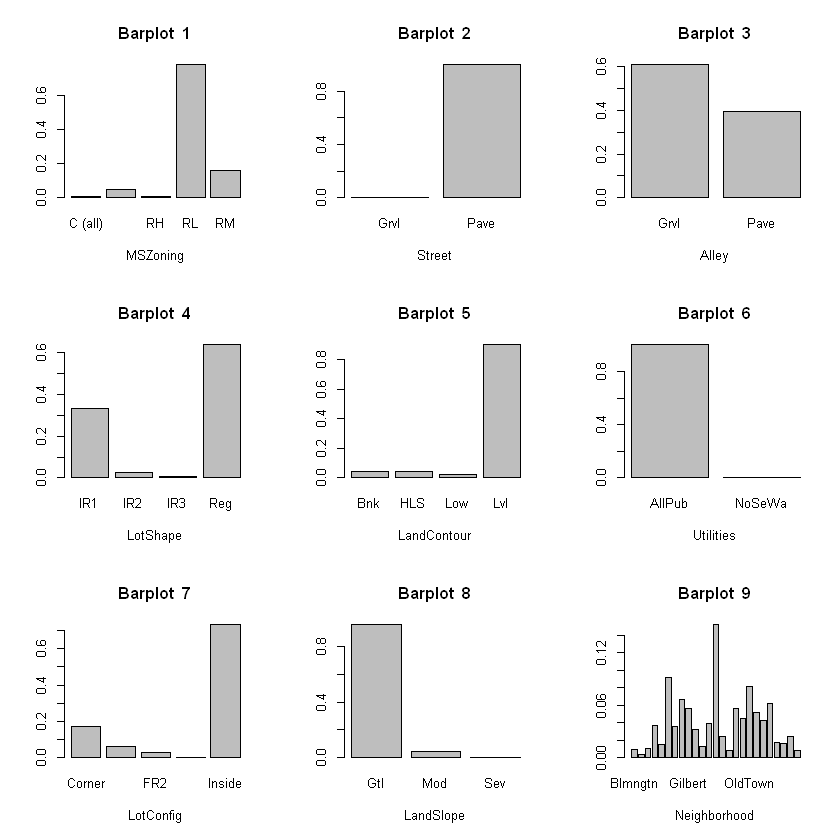

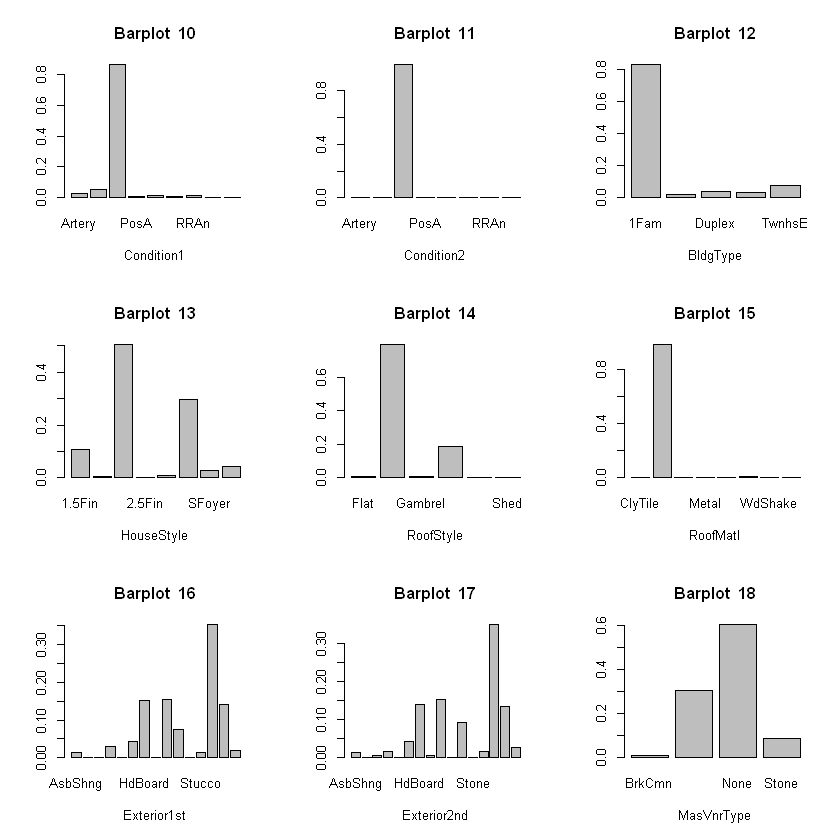

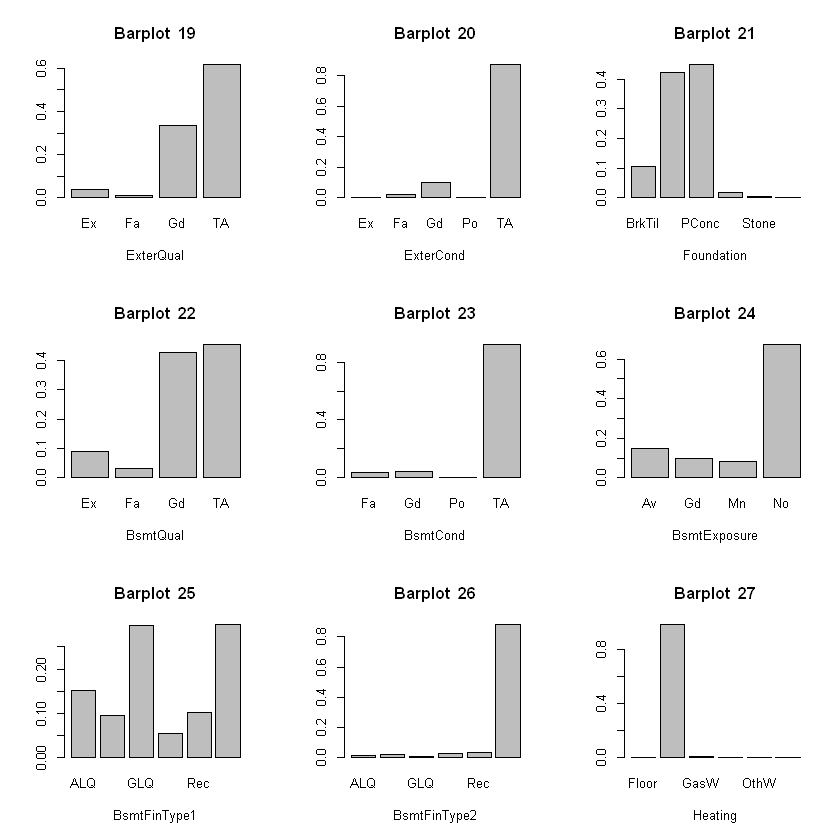

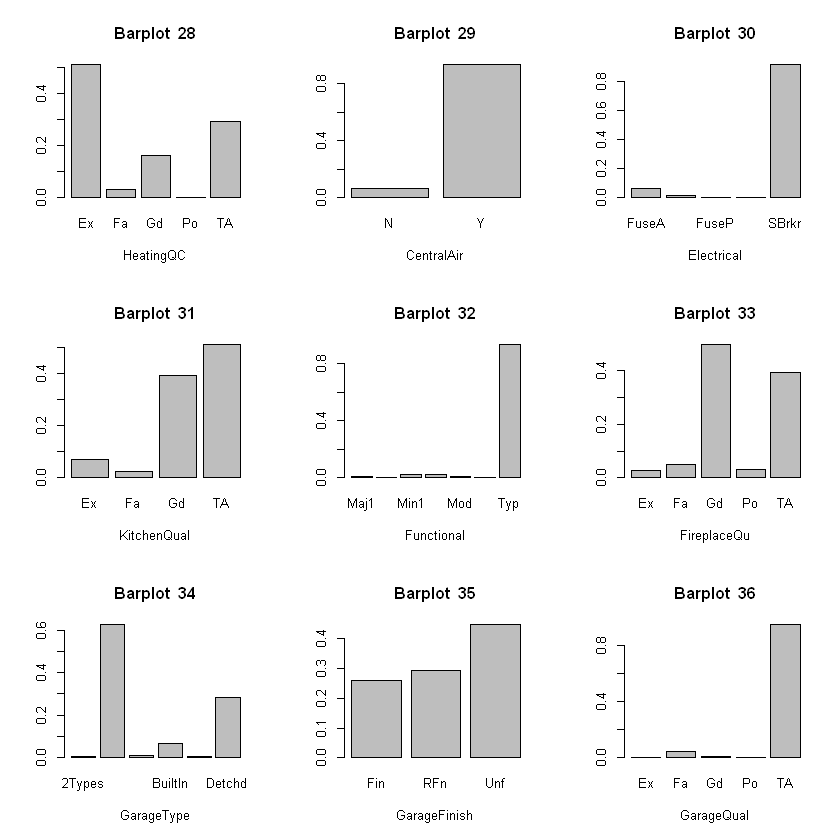

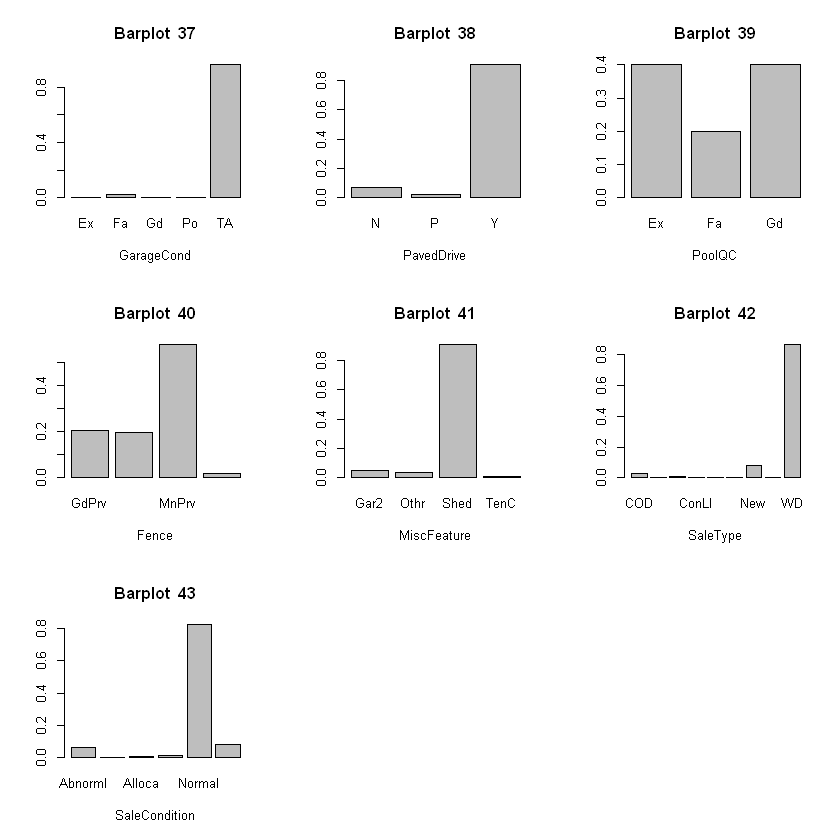

In [6]:
par(mfrow=c(3,3))
plotHist(categoric.df, 1:ncol(categoric.df))

By looking at the histograms for categorical data remove all feature where most values fall into 1 cat:

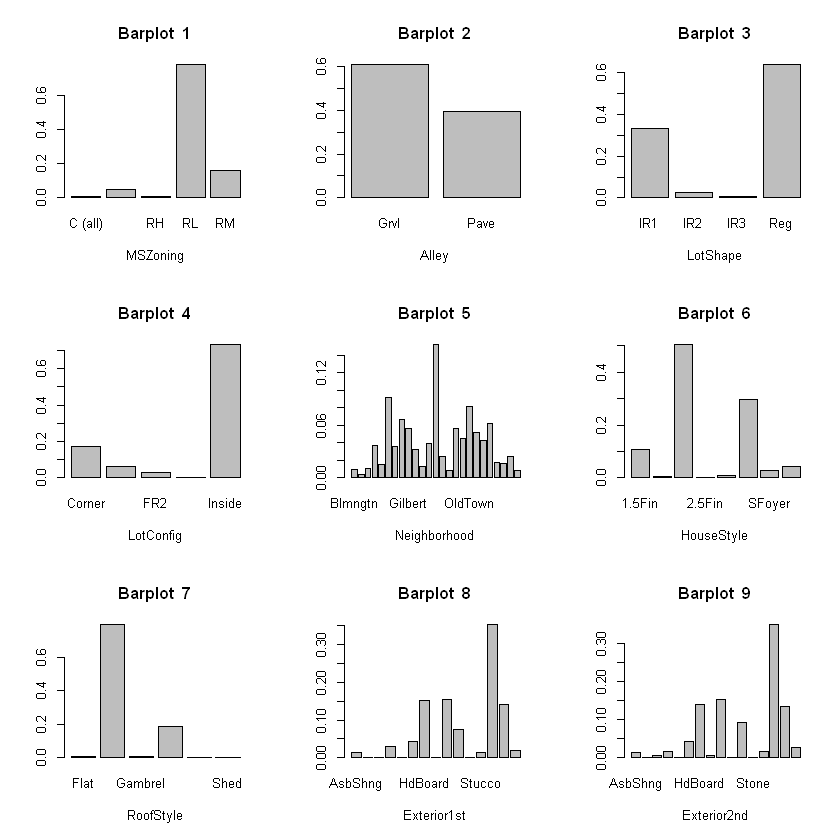

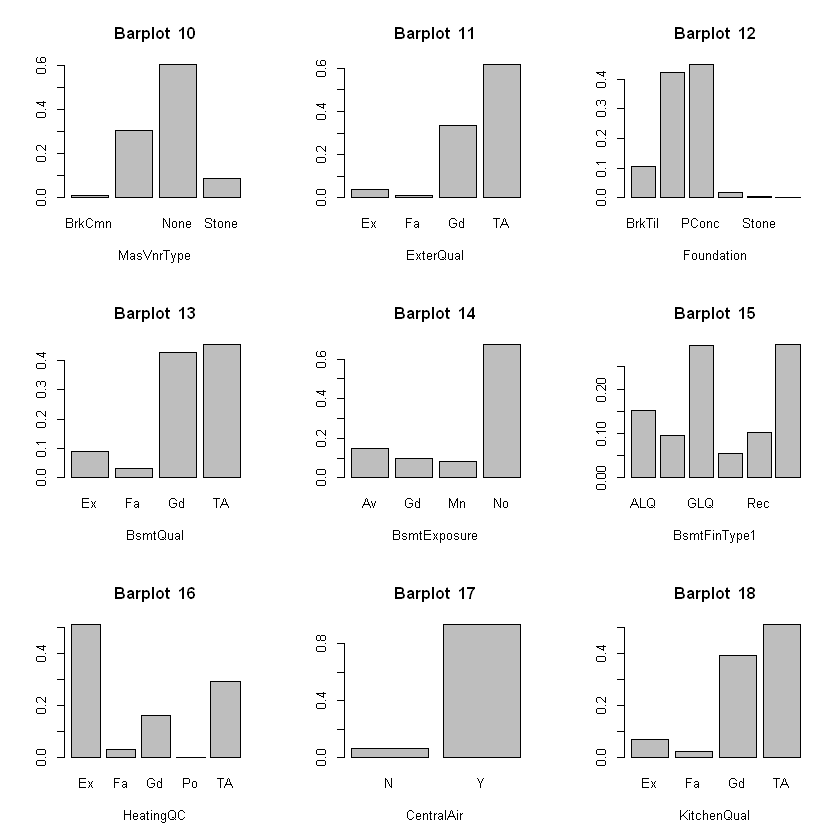

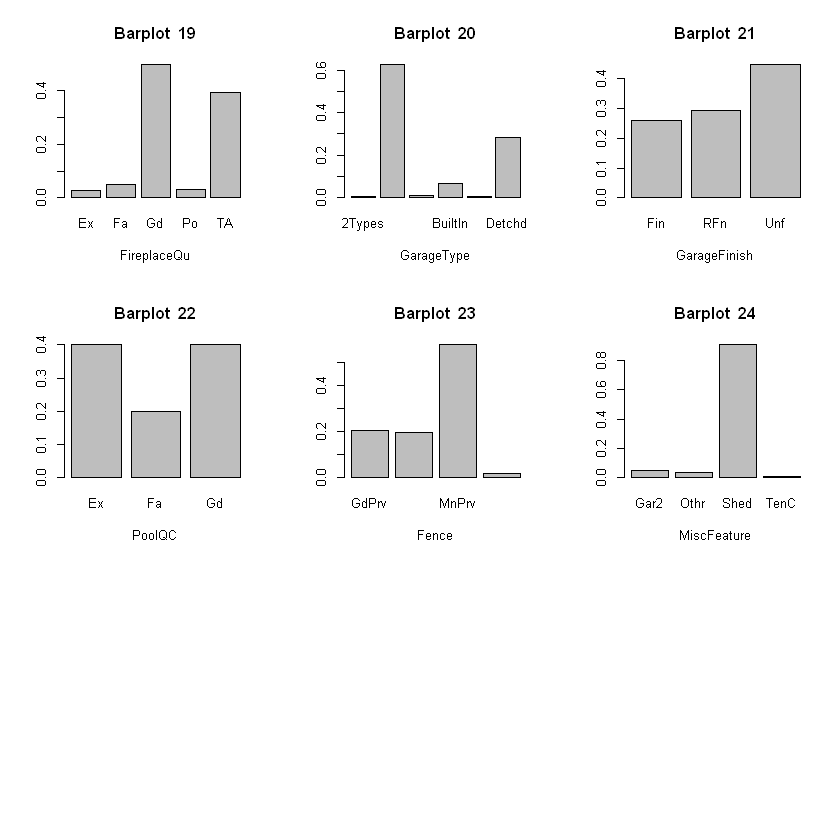

In [7]:
one_dominant_feature <- c('Street',"LandContour","Utilities", "LandSlope", 'Condition1', 'Condition2', 'BldgType', 'RoofMatl',
                          'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional', 'GarageQual',
                          "GarageCond","PavedDrive" , "SaleType" , "SaleCondition")

categoric.df <- categoric.df[,setdiff(names(categoric.df), one_dominant_feature)]
par(mfrow=c(3,3))
plotHist(categoric.df, 1: ncol(categoric.df))

Remove all features for which we don't have enough data:

In [8]:
not_enough_data <- c('MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 
                     'BsmtFinType1', 'MasVnrType', 'GarageType', 'CentralAir' , 'Alley')

categoric.df <- categoric.df[,setdiff(names(categoric.df), not_enough_data)]


colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           4            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           1            1            0            0            0            1

Impute missing values with the most frequent value on the column:


In [9]:
categoric.df[is.na(categoric.df$MSZoning), 'MSZoning'] <-names(sort(table(categoric.df$MSZoning), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior1st), 'Exterior1st'] <-names(sort(table(categoric.df$Exterior1st), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior2nd), 'Exterior2nd'] <-names(sort(table(categoric.df$Exterior2nd), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$KitchenQual), 'KitchenQual'] <-names(sort(table(categoric.df$KitchenQual), decreasing = TRUE)[1])


#Make sure there are no missing values
colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           0            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           0            0            0            0            0            0

One hot encoding phase:

In [10]:
dim(categoric.df)

#one hot encoding phase
data_factor_onehot <- dummy.data.frame(categoric.df, sep="_")
dim(data_factor_onehot)

[1] 2919   12

[1] 2919  103

Make sure that we have valid column names as we are going to use this dataset for training.

Some packages like lazy or tree fail to process dataframe with column names containing spaces.

In [11]:
names(data_factor_onehot) <- make.names(names(data_factor_onehot), unique=TRUE)

### Numeric data visualisation and imputation 

In [12]:
colSums(is.na(numeric.df))
numeric.df$Id <-NULL #remove id

Id    MSSubClass   LotFrontage       LotArea   OverallQual 
            0             0           486             0             0 
  OverallCond     YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1 
            0             0             0            23             1 
   BsmtFinSF2     BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF 
            1             1             1             0             0 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
            0             0             2             2             0 
     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces 
            0             0             0             0             0 
  GarageYrBlt    GarageCars    GarageArea    WoodDeckSF   OpenPorchSF 
          159             1             1             0             0 
EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea       MiscVal 
            0             0             0             0             0 
       MoSold        YrSold 
            0             0

Let's find relationships between features.

All basement features seem to be related

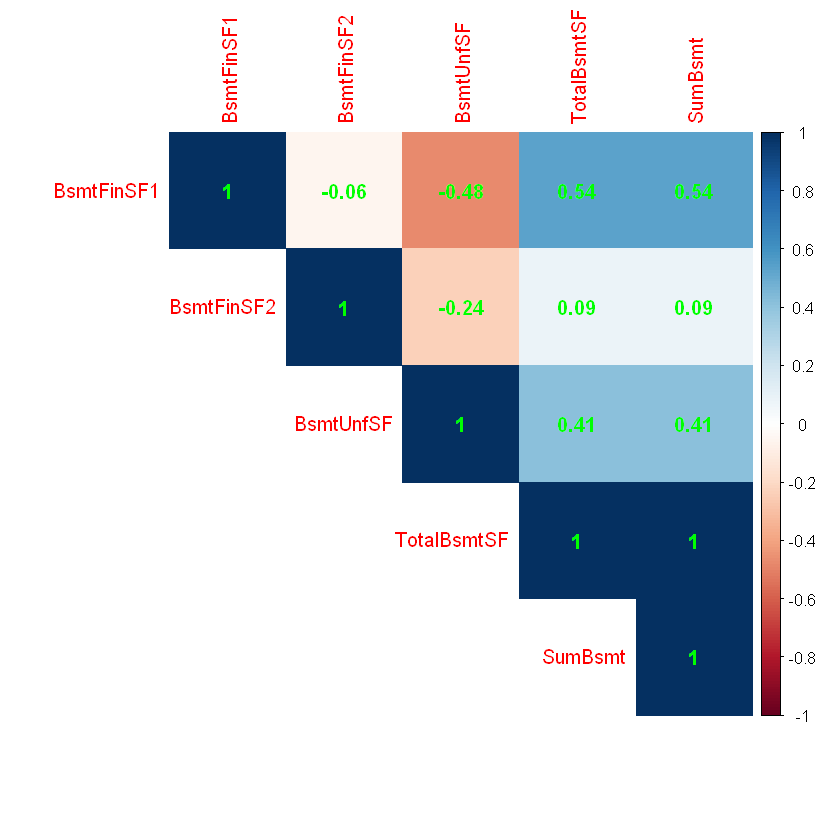

In [13]:
if( 'BsmtFinSF1' %in% names(numeric.df) ){
    bsmt <- numeric.df[, c('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF')]
    bsmt$SumBsmt <- bsmt$BsmtFinSF1 + bsmt$BsmtFinSF2 + bsmt$BsmtUnfSF
    par(mfrow=c(1,1))
    corrplot(cor(bsmt,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because TotalBsmtSF is totally corellated with the sum of 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' we
    #can simplify our model by keeping just the total
    numeric.df$BsmtFinSF1 <- NULL  
    numeric.df$BsmtFinSF2 <- NULL 
    numeric.df$BsmtUnfSF <- NULL 
}


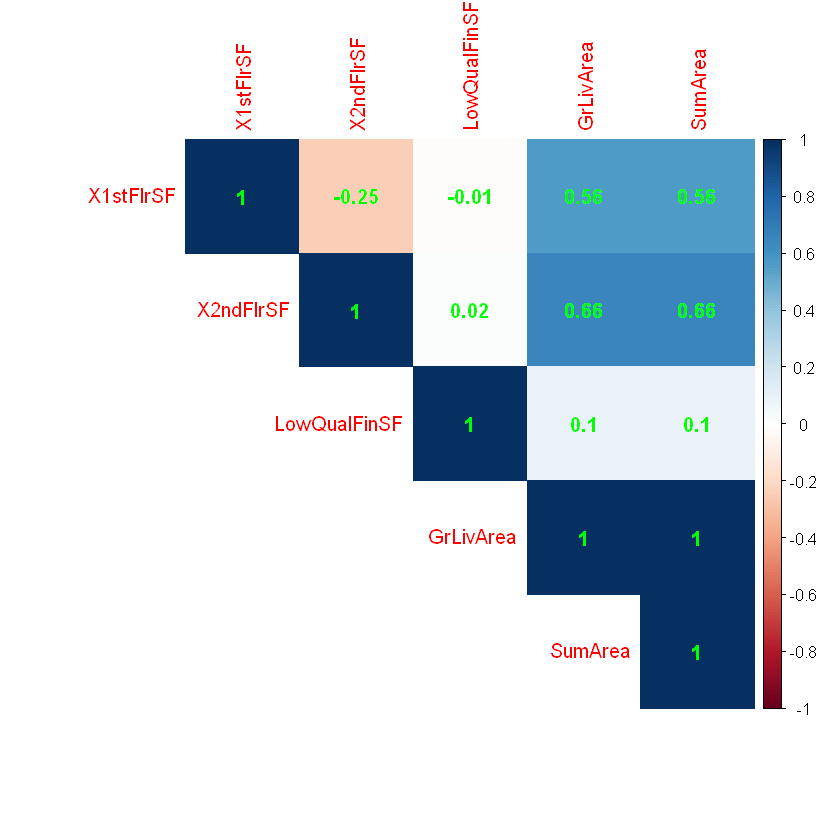

In [14]:
#Ground area surfaces also seem to be related
if( 'X1stFlrSF' %in% names(numeric.df) ){
    area <- numeric.df[, c('X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea')]
    area$SumArea <- area$X1stFlrSF + area$X2ndFlrSF + area$LowQualFinSF
    par(mfrow=c(1,1))
    corrplot(cor(area,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because GrLivArea is totally corellated with the sum of 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF' we
    #can simplify our model by keeping just the total
    numeric.df$X1stFlrSF <- NULL  
    numeric.df$X2ndFlrSF <- NULL 
    numeric.df$LowQualFinSF <- NULL 
}

In [15]:
#Remove features with a lot of missing data
numeric.df$LotFrontage <- NULL
numeric.df$GarageYrBlt <- NULL

In [16]:
#For remaining features let's impute with mean
replace_na_with_mean_value <- function(vec) {
  mean_vec <- mean(vec, na.rm = TRUE)
  vec[is.na(vec)] <- mean_vec
  vec
}


numeric.df <- data.frame(apply(numeric.df, 2, replace_na_with_mean_value))

At this point we have no missing data!

In [17]:
colSums(is.na(numeric.df))

MSSubClass       LotArea   OverallQual   OverallCond     YearBuilt 
            0             0             0             0             0 
 YearRemodAdd    MasVnrArea   TotalBsmtSF     GrLivArea  BsmtFullBath 
            0             0             0             0             0 
 BsmtHalfBath      FullBath      HalfBath  BedroomAbvGr  KitchenAbvGr 
            0             0             0             0             0 
 TotRmsAbvGrd    Fireplaces    GarageCars    GarageArea    WoodDeckSF 
            0             0             0             0             0 
  OpenPorchSF EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea 
            0             0             0             0             0 
      MiscVal        MoSold        YrSold 
            0             0             0

### Ouput overview

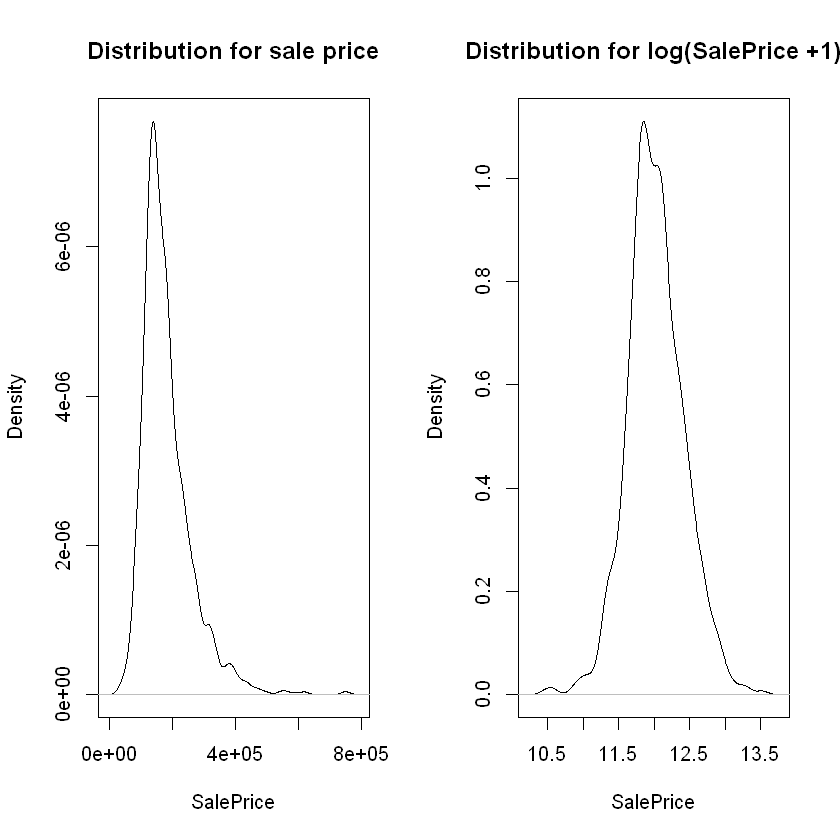

In [18]:
par(mfrow=c(1,2))
#let's examine the output
plot(density(input$SalePrice), xlab = 'SalePrice', 'Distribution for sale price') 
#the distribution of sale prices is right-skewed and does not follow a gaussian
plot(density(log(input$SalePrice + 1)), xlab = 'SalePrice', 'Distribution for log(SalePrice +1)')

In [19]:
#From the 103 one hot encoded variables only keep the ones at least slightly correlated with the output
cat.corr.df = cbind(data_factor_onehot[1:nrow(input),], SalePrice = Y)
cat.correlations <- abs(cor(cat.corr.df))

# only want the columns that show strong correlations with SalePrice, bigger than 0.2
cat.corr.SalePrice = as.matrix(sort(cat.correlations[,'SalePrice'], decreasing = TRUE))
cat.corr.idx = names(which(apply(cat.corr.SalePrice, 1, function(x) (x > 0.2))))
#corrplot(as.matrix(cat.correlations[cat.corr.idx ]), type = 'upper', method='color', addCoef.col = 'green')

correlated_data_factor_one_hot <-data_factor_onehot[, which(apply(cat.corr.SalePrice, 1, function(x) (x > 0.2)))]

dim(correlated_data_factor_one_hot)

#let's combine numeric and categorical into one dataset    
data <- cbind(numeric.df, correlated_data_factor_one_hot)
dim(data)


[1] 2919   25

[1] 2919   53

In [20]:
#data <- cbind(numeric.df, data_factor_onehot)
X<- data[1:nrow(input),]
Y<-log(input$SalePrice + 1)
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

train<-cbind(X ,SalePrice=Y)
test <- data[(nrow(input) + 1):nrow(numeric.df),]
dim(data)

[1] 2919   53

In [21]:
lmModel <- lm(SalePrice~. , train)
lmPred <- predict(lmModel, X)

Warning message in predict.lm(lmModel, X):
"prediction from a rank-deficient fit may be misleading"

The exception above is determined by the fact that introducing the one hot encoded variables we created a multicollinearity problem.

In statistics, multicollinearity (also collinearity) is a phenomenon in which two or more predictor variables in a multiple regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy.

This problem can be solved by removing the aliased columns as below:

In [22]:
aliasedHeaders <- names(summary(lmModel)$aliased[summary(lmModel)$aliased==TRUE])
aliasedHeaders
data <- data[,setdiff(names(data), aliasedHeaders)]
dim(data)

train<-cbind(data[1:nrow(input),] ,SalePrice=Y)

#this proves the problem is solved
lmModel <- lm(SalePrice~. , train)
lmPred <- predict(lmModel, train)


[1] "MSZoning_RM"      "LotShape_Reg"     "LotConfig_Inside"

[1] 2919   50

Let's remove all variables very uncorrelated to the output:

In [23]:
cat.correlations <- abs(cor(train))

# only want the columns that show strong correlations with SalePrice, bigger than 0.2
cat.corr.SalePrice = as.matrix(sort(cat.correlations[,'SalePrice'], decreasing = TRUE))
cat.corr.idx = names(which(apply(cat.corr.SalePrice, 1, function(x) (x > 0.1))))
#corrplot(as.matrix(cat.correlations[cat.corr.idx ]), type = 'upper', method='color', addCoef.col = 'green')

length(cat.corr.idx)
#data <- data[, which(apply(cat.corr.SalePrice, 1, function(x) (x > 0.1)))]
#dim(data)

[1] 33

Let's check dependencies between features and SalePrice:


In [24]:
plotOutputDependency <- function(data_in, output, positions) {
  for (i in positions) {
    plot(data_in[[i]], output, xlab = colnames(data_in)[i], ylab = 'SalePrice', main = paste('Dependency ' , i))
  }
}

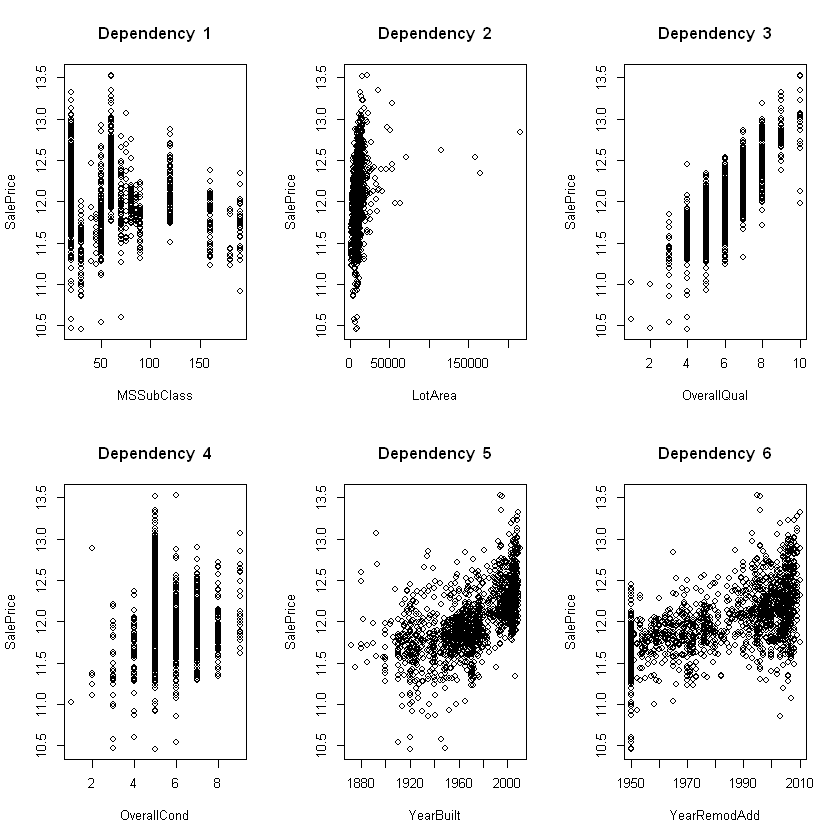

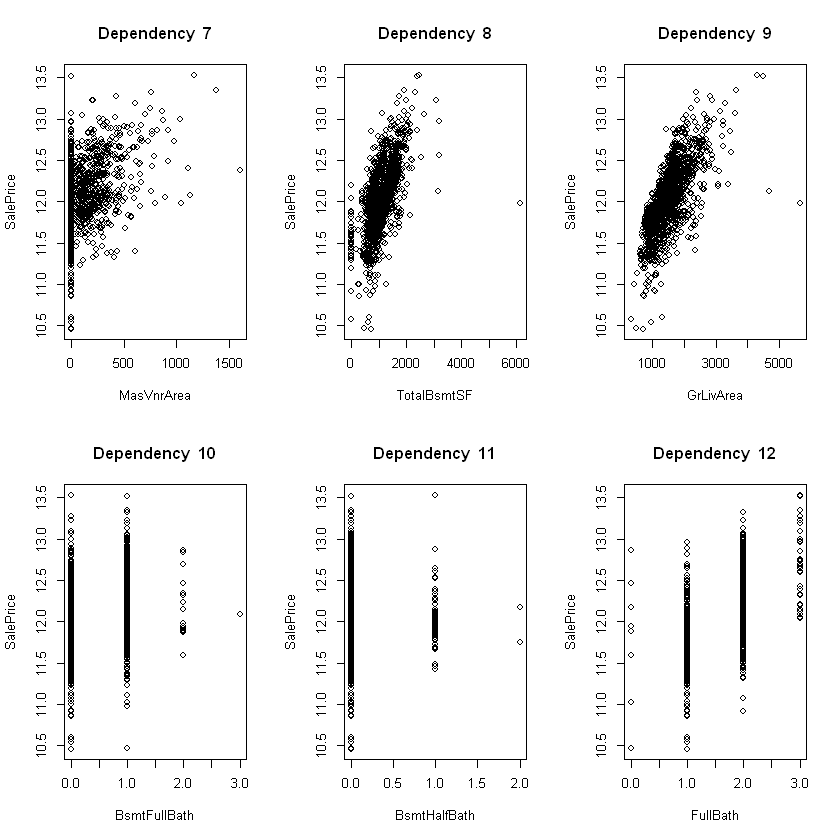

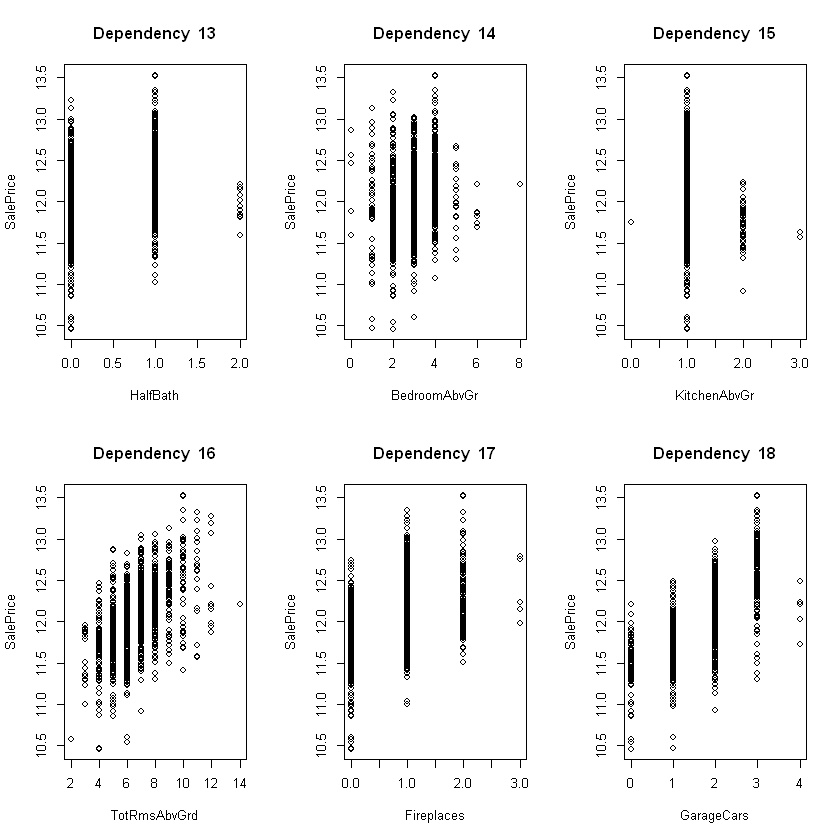

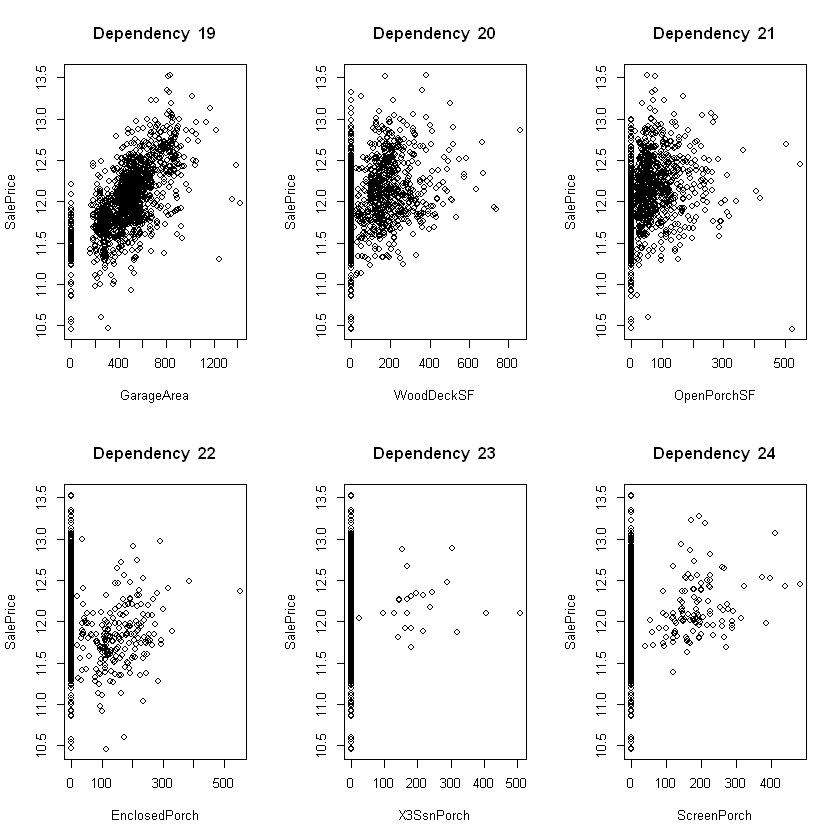

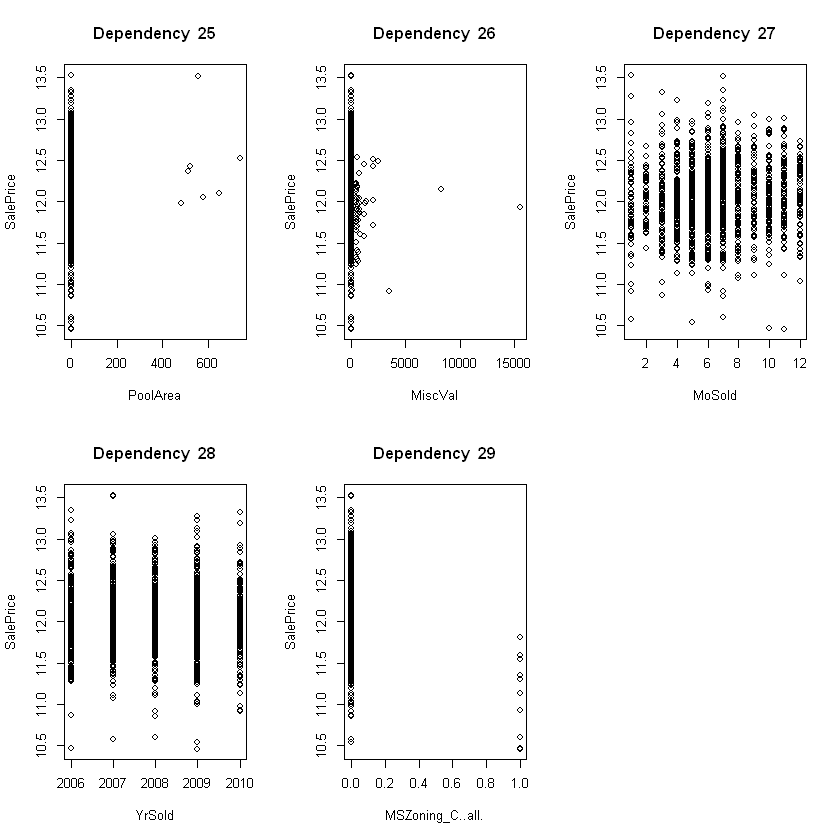

In [25]:
par(mfrow=c(2,3))
plotOutputDependency(X, Y, 1:29)

[1] 10

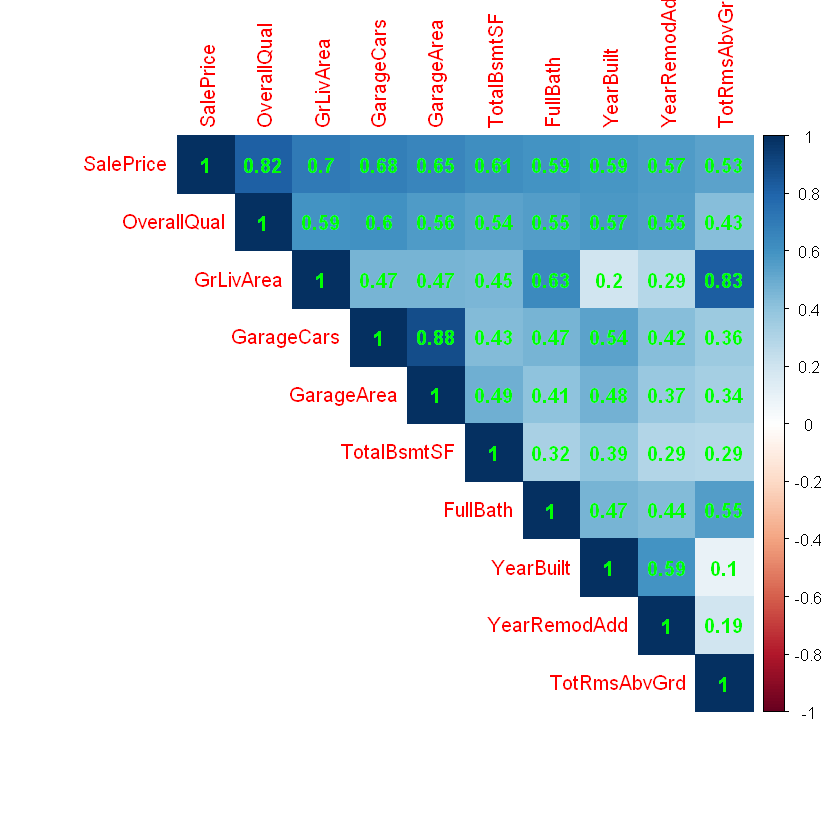

In [26]:
corr.df = cbind(X, SalePrice = Y)
correlations <- abs(cor(corr.df))

# only want the columns that show strong correlations with SalePrice, bigger than 0.5
corr.SalePrice = as.matrix(sort(correlations[,'SalePrice'], decreasing = TRUE))
corr.idx = names(which(apply(corr.SalePrice, 1, function(x) (x > 0.5))))

par(mfrow=c(1,1))
corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'green')
    
length(corr.idx) #we have 10 features with a significative correlation with SalePrice


In [27]:
X<- data[1:nrow(input),]
Y<-log(input$SalePrice + 1)
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables
    

In [28]:
dim(data) 

[1] 2919   50

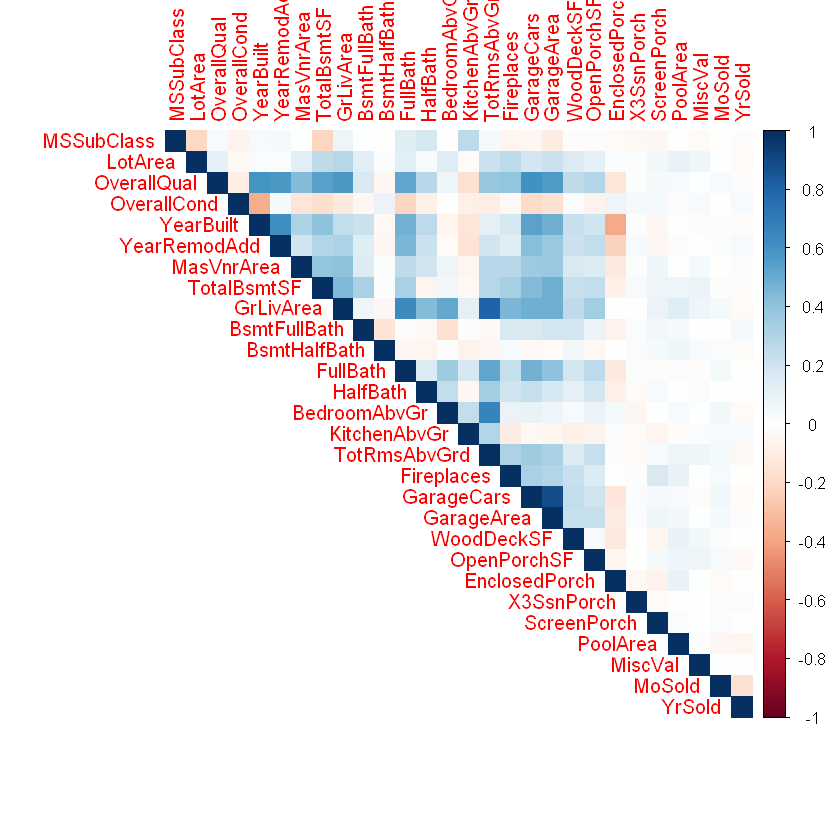

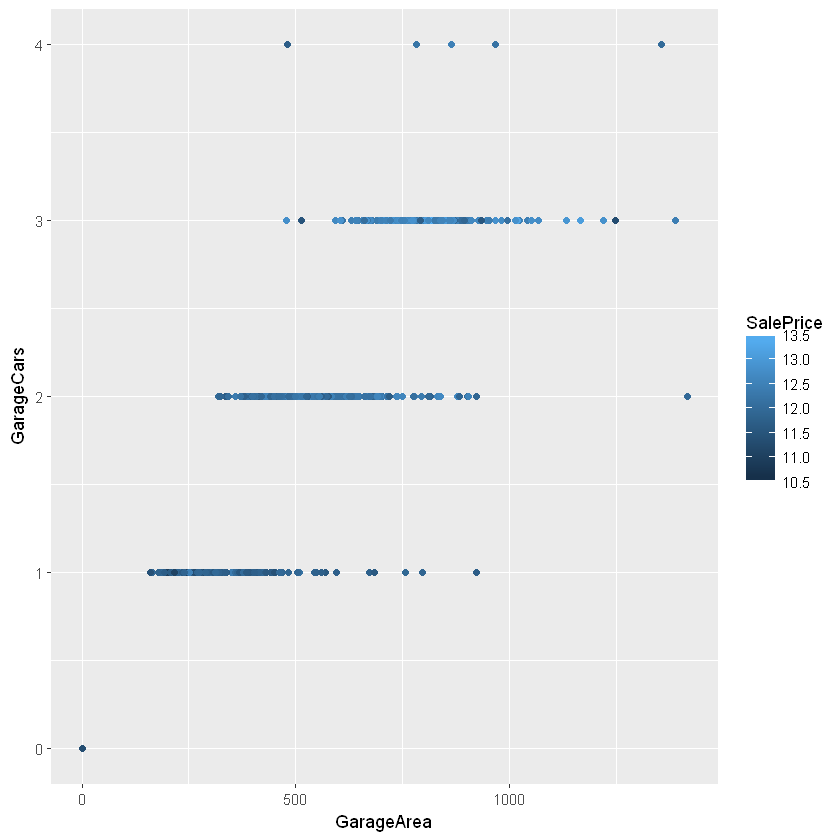

In [29]:
#Explore possible correlations between parameters
corrplot(cor(numeric.df,use="complete.obs"),type = 'upper', method='color')

ggplot(train, aes(x = GarageArea, y = GarageCars, color = SalePrice)) +
  geom_point() + scale_fill_brewer(palette = "Spectral")

There are some dependencies we can explore in order to reduce features, for instance GarageArea is liniarly dependent on GarageCars.

We can do the same thing for categorical data too.

The root mean squared error function between the logarithm of the predicted value and the logarithm of the observed sales price to evaluate model performance:

\begin{equation}
 RMSE=\sqrt{\frac{\sum_{i=1}^N (\hat{y_i} - y_i)^2}{N}}
\end{equation}

In [30]:
rmse <- function (log_prediction, log_observation){
  sqrt(mean(log_prediction-log_observation)^2)
}


The following functions implement scaling/unscaling operations:

In [450]:
unscale <- function (v, original_sd, original_mean){
  v * original_sd + original_mean
}

my_scale <- function(v){
    (v - mean(v)) / sd(v)
}

scale_df <- function(df) {
    data.frame(apply(df,2,my_scale))
}


## Feature selection

The section below implements the following feature selection algorithms: 
- Output correlation
- Minimum redundancy maxium relevance
- Principal component analysis
- Forward selection

Each implementation was designed as a configurable building block, taking as parameter the model on which we want to predict and the input/ output.

These building blocks will calculate the dependency between the number of features and the RMSE of resulting predictions vs observations. For a better visualisation, these methods also plot this dependency.

The goal is to select the optimal number of features which minimises RMSE. 

In order to avoid problems like overfitting, RMSE is calculated on the results obtained after running cross validation.

### What is cross validation ?

Cross-validation is a technique used to protect against overfitting in a predictive model, particularly in a case where the amount of data may be limited. In cross-validation,a fixed number of folds (or partitions) of the data is choseen and run the analysis on each fold, and then average the overall error estimate.

The pseudocode below explains the implementation of cross validation which will be recurrent in all building blocks:

```
size.CV<-floor(N/10) # number of observations per fold
CV.err<-matrix(0,nrow=n,ncol=10)

for (i in 1:10) {
    #i.ts holds the indexes of current fold on which we test
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  

    
    X.ts<-X[i.ts,]  #test data
    Y.ts<-Y[i.ts]  #actual output value

    i.tr<-setdiff(1:N,i.ts) # indexes for input data = everything - test fold
    X.tr<-X[i.tr,] 
    Y.tr<-Y[i.tr]
    //do stuff : create model , predict result in Y.hat.ts
    
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
}
# average all cross validation errors
apply(CV.err,1,mean)

```

### Output correlation

The following code selects in order the most correlated features with the output:


In [213]:

outputCorrelation <- function(modelName, X, Y){
  n <- ncol(X)
  size.CV<-floor(N/10)
  ranking <- numeric(n)
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    
    
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    #sometimes in the sampling process sd is 0 so let's remove those features because
    #calculating corelation on them would be a division by 0
    #X.tr <- X.tr[,which(apply(X.tr, 2, sd)!=0)]
    correlation<-abs(cor(X.tr,Y.tr))
    ranking<-sort(correlation,dec=T,index.return=T)$ix
    
    for (nb_features in 1:length(ranking)) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'svm'){
        #model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
         #            shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])$h
      }
      if(modelName == 'ridge'){
          #for linear ridge we need at least 2 features
          if (nb_features != 1){
             #DS is performing a sdv which fails for columns with 0 after scaling
             #let's remove these columns
             DS <- DS[,which(colSums(DS)!=0)]
             model<- linearRidge(SalePrice~.,DS)
             model<- linearRidge(SalePrice~.,DS)
             Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
          } 
      }
      
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' filter feature'), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste( modelName, " filter features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  ranking
}




### MRMR
The minimum redundancy maximum relevance feature selection strategy approximates


\begin{equation}
  \arg\max_{x_{k}\in X - X_{S}} \left(I\left\{X_{S}; x_{k}\right\};y\right)
\end{equation}


with


\begin{equation}
  x^*_{MRMR}=\arg\max_{x_{k}\in X - X_{S}} \left[I(x_{k}; y) - \frac{1}{m} \sum_{x_{i}\in X_{S}} I(x_{i}; x_{k})\right]
\end{equation}

where $m$ is the size of $X_S$


MRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables.

At each step we calculate the correlation between the selected variables and the remaining ones and we penalise the ones correlated with the ones we already selected.



In [216]:
mrmr <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    
    correlation<-abs(cor(X.tr,Y.tr))
    
    selected<-c()
    candidates<-1:n
    
    for (j in 1:n) {
      redudancy.score<-numeric(length(candidates))
      if (length(selected)>0) {
        cor.selected.candidates<-cor(X.tr[,selected,drop=F],X.tr[,candidates,drop=F])
        redudancy.score<-apply(cor.selected.candidates,2,mean)
      }
      
      mRMR.score<-correlation[candidates]-redudancy.score
      selected_current<-candidates[which.max(mRMR.score)]
      selected<-c(selected,selected_current)
      candidates<-setdiff(candidates,selected_current)
      #print(paste(' mRMR.score: ', mRMR.score, ' selected_current : ', selected_current, ' selected :' , selected, ' candidates: ', candidates))
    }
    
    ranking<-selected
    
    for (nb_features in 1:n) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #         shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])$h
      }
      if(modelName == 'ridge'){
          #for linear ridge we need at least 2 features
          if (nb_features != 1){
                #DS is performing a sdv which fails for columns with 0 after scaling
                #let's remove these columns
                DS <- DS[,which(colSums(DS)!=0)]
                model<- linearRidge(SalePrice~.,DS)
                Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
         }
      }
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' MRMR'), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste(modelName , "Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  print(selected)
  selected
}



### PCA

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components (or sometimes, principal modes of variation). The number of principal components is less than or equal to the smaller of the number of original variables or the number of observations. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

The following code performs features selection by first transforming the inputs using PCA, and then keeping the most relevant principal components in the model.

It projects the input data into a lower dimensional space and creates linear combinations of original axes ( it creates a completely new set of features):

In [206]:

pca <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  X_pca<-data.frame(prcomp(X,retx=T)$x)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X_pca[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X_pca[i.tr,]
    Y.tr<-Y[i.tr]
    
    for (nb_features in 1:n) {
      DS<-cbind(X.tr[,1:nb_features,drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
         #            shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,1:nb_features,drop=F])$h
      }
      if(modelName == 'ridge'){
        #DS is performing a sdv which fails for columns with 0 after scaling
        #let's remove these columns
        DS <- DS[,which(colSums(DS)!=0)]
        model<- linearRidge(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' PCA '), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste(modelName ," Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  X_pca
}



### Forward selection

The following code performs features selection by using a forward selection method.

We add variables to the model one at a time. At each step, each variable that is not already in the model is tested for inclusion in the model in order to minimize the CV error.

In [218]:
forwardSelection <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  selected<-NULL
  
  for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV.err<-matrix(0,nrow=length(candidates),ncol=10)
    
    for (j in 1:length(candidates)) {
      features_to_include<-c(selected,candidates[j])
      
      for (i in 1:10) {
        i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
        X.ts<-X[i.ts,features_to_include,drop=F]  
        Y.ts<-Y[i.ts]  
        
        i.tr<-setdiff(1:N,i.ts)
        X.tr<-X[i.tr,features_to_include,drop=F]
        Y.tr<-Y[i.tr]
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'svm'){
          #model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
          #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
          model<- svm(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){
          #DS <- scale(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts<- predict(model,X.ts)$h
        }
        if(modelName == 'ridge'){
            #for linear ridge we need at least 2 features
          if (nb_features != 1){
              #DS is performing a sdv which fails for columns with 0 after scaling
             #let's remove these columns
              DS <- DS[,which(colSums(DS)!=0)]
              model<- linearRidge(SalePrice~.,DS)
              Y.hat.ts <- predict(model,X.ts)
            }
        }
        
        CV.err[j,i]<-rmse(Y.hat.ts,Y.ts)
      }
    }
    CV.err.mean<-apply(CV.err,1,mean)
    CV.err.sd<-apply(CV.err,1,sd)
    selected_current<-which.min(CV.err.mean)              
    selected<-c(selected,candidates[selected_current])
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV.err.mean[selected_current],digits=4), " ; std dev=",round(CV.err.sd[selected_current],digits=4)))
    
  }
  
  selected
}


## Model Evaluation

The following section aims at assessing the performance of various models assuming the input parameter X contains already filtered features.

The goal is to easily plug in various models and combinations of features and test how they perform on RMSE.

### Simple runModel

The following method evaluates via cross validation the given model (modelName) on the entire data set:

In [208]:

runModel <- function(modelName, X, Y, nFold){
  
  size.CV<-floor(N/nFold)
  
  CV.err<-numeric(nFold)
  
  for (i in 1:nFold) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)  
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]                          
    
    DS<-cbind(X.tr,SalePrice=Y.tr)
    
    
    if(modelName == 'lm') {
      model<- lm(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'rpart') {
      model<- rpart(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'tree') {
      model<- tree(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'svm'){
      model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'linear', 
                    shrinking = T, cross = 10, cost = 3, epislon = 0.2)
       # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
      #              shrinking = T, cross = 10, cost = 4, epislon = 0.2)
      #model<- svm(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'nnet'){
      #DS <- scale(DS)
      model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'lazy'){
      model<- lazy(SalePrice~.,DS)
      Y.hat.ts<- predict(model,X.ts)$h
    }
    if(modelName == 'ridge'){
      #DS is performing a sdv which fails for columns with 0 after scaling
      #let's remove these columns
      DS <- DS[,which(colSums(DS)!=0)]
      model<- linearRidge(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    CV.err[i]<-rmse(Y.hat.ts,Y.ts) 
  }
  print(paste(modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}


## Simple ensemble run model

The following method runs an ensemble of R (10) models of the same type on each of the 10 validation folds.

Before building the model, the training set is resampled R times.

The predictions of all models are being averaged.

In [36]:
runEnsemble <- function(modelName, X, Y){
  
  R<-10
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)               
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
    for (r in 1:R) {
      i.tr.resample<-sample(i.tr,rep=T)
      X.tr<-X[i.tr.resample,]
      Y.tr<-Y[i.tr.resample]       
      
      DS<-cbind(X.tr,SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'svm'){
         #model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
         #            shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'nnet'){
        #DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts.R[,r]<- predict(model,X.ts)$h
      }
      if(modelName == 'ridge'){
        model<- linearRidge(SalePrice~.,DS, all.coef = FALSE, nPCs = NULL )
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
  }
  
  
  print(paste('Ensemble ', modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}

### Ensemble average models

The ensemble method below splits the training set into CV folds and samples each one R times.

Because for each model we might have different relevant features, this method takes as first parameter the list of models and the second parameter is the list of features for each model.
The last 2 parameters are the number of resamples and the number of cross validation folds.

This method returns the CV error which can be for instance plotted later on (see ridge exploration below)

Example of usage: 

```
magicEnsemble(c('svm', 'lm'), list(svmIndexes, lmIndexes), X, Y, 5, 10) 
```

In [587]:
magicEnsemble <- function(models, modelFeatures, X, Y, R, CV){

  size.CV<-floor(N/CV)
  
  CV.err<-numeric(CV)
  
  for (i in 1:CV) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV)) 
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)        
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol= R * length(models))
    
    for( mi in 1: length(models)){
      modelName = models[mi]
      for (r in 1:R) {
        index <- (mi -1 ) * R + r
        
        i.tr.resample<-sample(i.tr,rep=T)
        if(R == 1) { #prevent resampling for R = 1
            i.tr.resample <- i.tr
        }
        
        X.tr<-X[i.tr.resample,]
        Y.tr<-Y[i.tr.resample]       
        
        #for each model feature, use its optimised features
        if(!is.null(modelFeatures) && !is.null(modelFeatures[[mi]])) {
          X.tr <- X.tr[, modelFeatures[[mi]]]
        }
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
          
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts.R[, index] <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS, method = "anova", minsplit=5, cp=2^(-5))
          Y.hat.ts.R[,index] <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,X.ts)
        }
        if(modelName == 'svm'){
          model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
                    shrinking = T, cross = 5, cost = 4, epislon = 0.2)

          #model<- svm(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){
          DS <- scale_df(DS)
          model<- nnet(SalePrice~.,DS, size =2, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
          #Y.hat.ts.R[,index] <- predict(model,X.ts)
          Y.hat.ts.R[,index] <- predict(model,scale_df(X.ts))
          Y.hat.ts.R[,index] <- unscale(Y.hat.ts.R[,index], sd(Y.tr), mean(Y.tr))
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts.R[,index]<- predict(model,X.ts)$h
        }
        
        if(modelName == 'ridge'){
          #DS is performing a sdv which fails for columns with 0 after scaling
          #let's remove these columns
          DS <- DS[,which(colSums(DS)!=0)]

          model<- linearRidge(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,X.ts)
        }
      }
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
    
  }
  
  print(paste('Magic Ensemble for', paste(models,collapse=","), "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
  round(mean(CV.err),digits=4)
}


### Stacked ensemble

The method below implements the stacked ensemble learning.
The basic idea is to train machine learning algorithms with training dataset and then generate a new dataset with these models. Then this new dataset is used as input for the combiner machine learning algorithm.


```
base_algorithms = [algorithm1, algorithm2, ...]

stacking_train_dataset = matrix(row_length=len(target), column_length=len(algorithms))
stacking_test_dataset = matrix(row_length=len(test), column_length=len(algorithms))


for i,base_algorithm in enumerate(base_algorithms):
    stacking_train_dataset[,i] = base_algorithm.fit(train, target).predict(train)
    stacking_test_dataset[,i] = base_algorithm.predict(test)

final_predictions = combiner_algorithm.fit(stacking_train_dataset, target).predict(stacking_test_dataset)
```

In [604]:
stackedEnsemble <- function(models, modelFeatures, X, Y, R, CV){

  size.CV<-floor(N/CV)
  
  CV.err<-numeric(CV)
  
  for (i in 1:CV) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV)) 
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)        
    stacking_train_dataset<-matrix(0,nrow=nrow(X.tr),ncol= R * length(models))
    stacking_test_dataset<-matrix(0,nrow=nrow(X.ts),ncol= R * length(models))
    
    for( mi in 1: length(models)){
      modelName = models[mi]
      for (r in 1:R) {
        index <- (mi -1 ) * R + r
        
        i.tr.resample<-sample(i.tr,rep=T)
        if(R == 1) { #prevent resampling for R = 1
            i.tr.resample <- i.tr
        }
        
        X.tr<-X[i.tr.resample,]
        Y.tr<-Y[i.tr.resample]       
        
        #for each model feature, use its optimised features
        if(!is.null(modelFeatures) && !is.null(modelFeatures[[mi]])) {
          X.tr <- X.tr[, modelFeatures[[mi]]]
        }
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
          
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS, method = "anova", minsplit=5, cp=2^(-5))
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
            
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,X.ts)

        }
        if(modelName == 'svm'){
          model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
                    shrinking = T, cross = 5, cost = 4, epislon = 0.2)

          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){

          model<- nnet(SalePrice~.,DS, size =2, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,X.ts)
            
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          stacking_train_dataset[,index] <- predict(model,X.tr)$h
          stacking_test_dataset[,index] <- predict(model,X.ts)$h
        }
        
        if(modelName == 'ridge'){
          #DS is performing a sdv which fails for columns with 0 after scaling
          #let's remove these columns
          DS <- DS[,which(colSums(DS)!=0)]

          model<- linearRidge(SalePrice~.,DS)
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,X.ts)
        }
      }
    }
    

    stacked <- as.data.frame(stacking_train_dataset)

    stacked$SalePrice <- Y.tr
    #model<- nnet(SalePrice~.,stacked,  size =2, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
    #model<- lm(SalePrice~.,stacked)
    model<- linearRidge(SalePrice~.,stacked)
    
    p <- predict(model,as.data.frame(stacking_test_dataset))

    CV.err[i]<-rmse(p,Y.ts)
    
  }
  
  print(paste('Magic Ensemble for', paste(models,collapse=","), "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
  round(mean(CV.err),digits=4)
}


## Model and feature selection


In this paper we will analyse the performance of the following algorithms:
- Decision trees (rpart)
- Support vector machines (svm)
- K-nearest neighbors (lazy)
- Regression tree (tree)
- Liniar model (lm)
- Neural Network (nnet)
- Ridge regression (linearRidge)

By calculating the root mean square error between predictions and observations on cross validation folds.

For feature selection the following approaches have been implemented as model dependent methods (see above) :

- Output correlation
- Minimum redundancy maxium relevance
- Principal component analysis
- Forward selection





## RPART

In [38]:
X<- data[1:nrow(input),]
runModel('rpart', X, Y, 5) 

[1] "rpart   CV error= 0.0163  ; std dev= 0.0155"


rpart  filter features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart  filter features:  2  ; CV error= 0.0162  ; std dev= 0.0101
rpart  filter features:  3  ; CV error= 0.0139  ; std dev= 0.0101
rpart  filter features:  4  ; CV error= 0.0133  ; std dev= 0.0101
rpart  filter features:  5  ; CV error= 0.0141  ; std dev= 0.0117
rpart  filter features:  6  ; CV error= 0.0146  ; std dev= 0.0111
rpart  filter features:  7  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  8  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  9  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  10  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  11  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  12  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  13  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  14  ; CV error= 0.0142  ; std dev= 0.0121
rpart  filter features:  15  ; CV error= 0.0142  ; std dev= 0.0121
rpar

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21 32  2 33 49 10 47 14 29 43 50 15
[26] 22 37 42 24 34 30 45 46 44 48  1 31 25 27 28  4 40 23 35 26 41 36 11 39 38

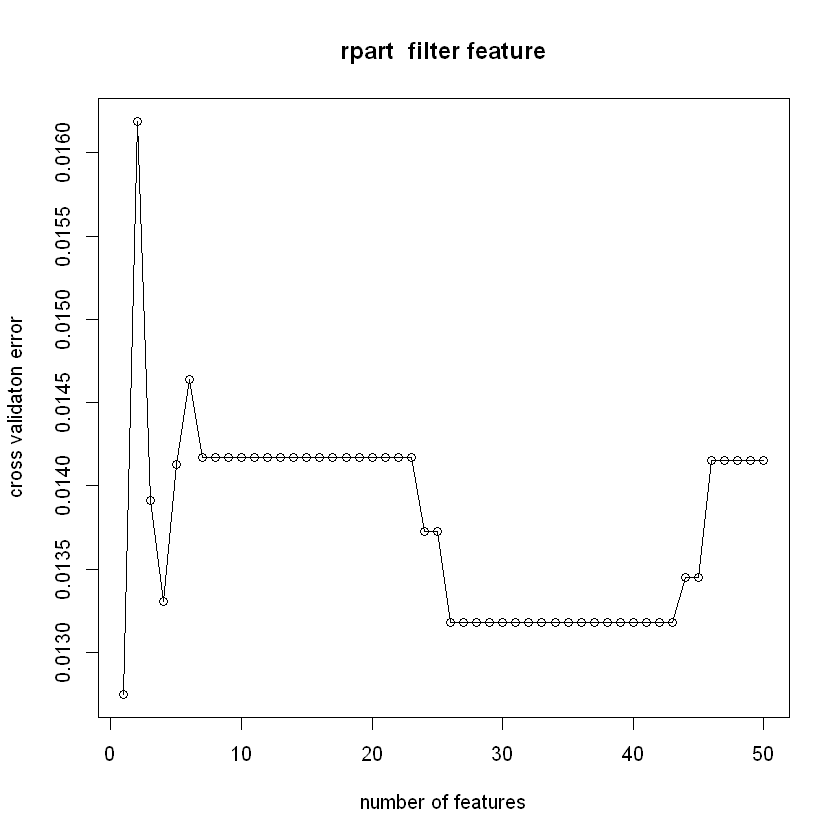

In [123]:
#outputCorrelation('rpart', X, Y) #26  ; CV error= 0.0132  ; std dev= 0.0114

rpart Features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart Features:  2  ; CV error= 0.0145  ; std dev= 0.0108
rpart Features:  3  ; CV error= 0.0145  ; std dev= 0.0108
rpart Features:  4  ; CV error= 0.017  ; std dev= 0.0111
rpart Features:  5  ; CV error= 0.0129  ; std dev= 0.0097
rpart Features:  6  ; CV error= 0.0129  ; std dev= 0.0097
rpart Features:  7  ; CV error= 0.0147  ; std dev= 0.0085
rpart Features:  8  ; CV error= 0.0138  ; std dev= 0.0123
rpart Features:  9  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  10  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  11  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  12  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  13  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  14  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  15  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  16  ; CV error= 0.0139  ; std dev= 0.0122
rpart Features:  17  ; CV error= 0.0139  ; std dev= 0.0122
rpart F

[1]  3 33 32  9 18 37  5  8  6 52 19 12 17 50 16 46  7 29 20 13 34 53 21 22  2
[26] 15 10 45 14 30 39 42 24 48 35 49 31  4 51 47  1 28 27 25 43 26 23 38 44 36
[51] 11 40 41

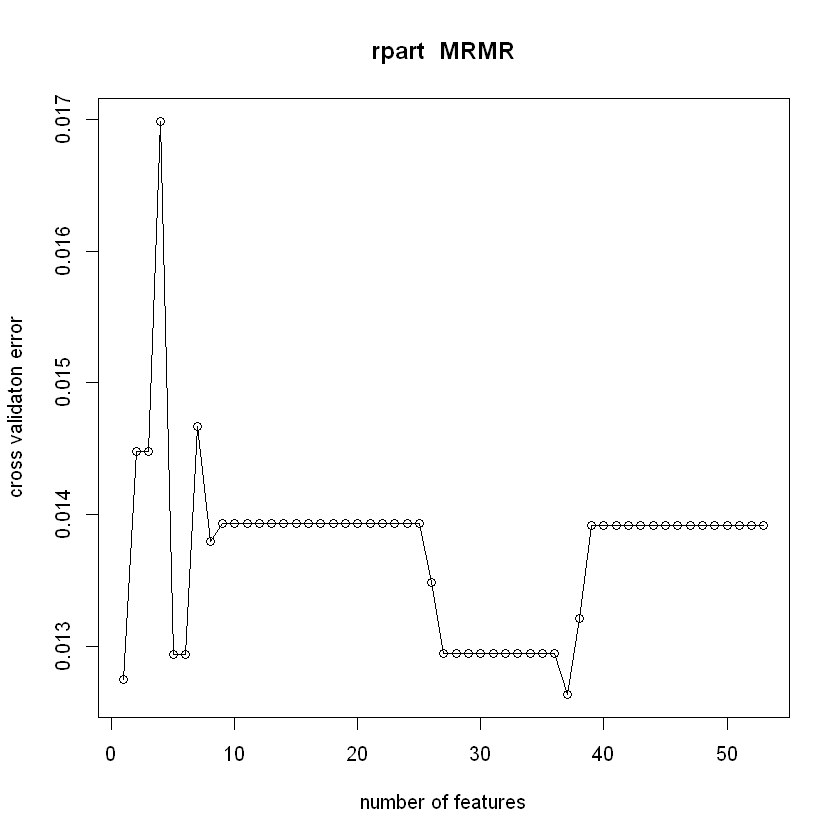

In [48]:
#mrmr('rpart', X, Y) #34  ; CV error= 0.0129  ; std dev= 0.0109

rpart  Features:  1  ; CV error= 0.0282  ; std dev= 0.0156
rpart  Features:  2  ; CV error= 0.0179  ; std dev= 0.0148
rpart  Features:  3  ; CV error= 0.0179  ; std dev= 0.0148
rpart  Features:  4  ; CV error= 0.0216  ; std dev= 0.0135
rpart  Features:  5  ; CV error= 0.0208  ; std dev= 0.0125
rpart  Features:  6  ; CV error= 0.0208  ; std dev= 0.0125
rpart  Features:  7  ; CV error= 0.0208  ; std dev= 0.0125
rpart  Features:  8  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  9  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  10  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  11  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  12  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  13  ; CV error= 0.0209  ; std dev= 0.0124
rpart  Features:  14  ; CV error= 0.0187  ; std dev= 0.0119
rpart  Features:  15  ; CV error= 0.0187  ; std dev= 0.0119
rpart  Features:  16  ; CV error= 0.0187  ; std dev= 0.0119
rpart  Features:  17  ; CV error= 0.0187  ; std d

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
-2065.8900,113.85787,24.586562,-263.05927,114.39034,-35.966998,98.251314,-22.2563486,8.991420,-33.5371991,...,-0.0361186178,-0.0134996699,-9.637035e-03,0.0158178409,0.010479243,0.0031713373,5.108912e-04,-1.800349e-15,9.852897e-15,4.226643e-15
-917.7324,-80.56677,56.802655,311.90552,-49.13922,79.873217,-212.211965,25.3229535,27.978980,-0.4423982,...,-0.0039664524,0.0791592561,-2.282335e-02,-0.0398591567,-0.021293703,0.0286470766,1.690550e-03,1.283989e-15,-1.439854e-14,-7.493149e-15
735.5653,164.30935,26.020367,-255.83505,121.88118,22.539234,108.322183,-3.6583613,25.798515,-35.5233323,...,0.0045835397,-0.0580196644,5.865202e-03,-0.0125646599,-0.002658810,-0.0040963616,3.305640e-03,-5.235930e-16,1.201783e-14,7.585068e-15
-967.1986,32.43131,29.024743,-356.47212,99.80338,180.994124,119.487181,181.4772171,-150.501842,69.9773916,...,-0.0101627556,0.0071614580,-3.748023e-02,-0.0896736628,-0.045738711,0.0030905821,-1.337442e-02,-2.601792e-15,2.751585e-14,2.265808e-14
3755.0246,646.20132,-4.414132,-287.38469,299.36149,-12.543487,-34.891756,-6.8897716,-6.894603,-19.3498569,...,-0.0060990404,-0.0449619854,-2.159463e-02,-0.0148031662,-0.010836986,0.0264627954,5.392760e-05,-5.127549e-15,1.893985e-15,1.954078e-14
3593.3691,-396.23283,-623.858069,-113.03379,49.45908,84.884211,45.014513,-12.0048528,28.845527,-43.2800847,...,0.0192001239,0.0159190477,-8.827009e-03,0.0557699450,-0.007157297,-0.0152493567,6.511404e-03,-1.433199e-14,7.091217e-15,7.883440e-15
-421.9633,547.43320,12.800868,428.32662,17.68625,18.335130,-127.213224,4.5789904,1.564307,-12.3107439,...,0.0081930929,0.0374832895,1.270482e-02,-0.0061500440,0.019783448,0.0109424068,-2.571335e-04,2.951965e-16,-1.487732e-14,1.499658e-15
-125.0050,497.46410,-354.835677,-278.47439,-24.62442,-89.219739,-102.538710,34.1781467,-241.090180,64.8879603,...,0.0273057340,-0.0173733275,-2.855771e-02,-0.0147581561,-0.010837674,-0.0075147045,3.196137e-03,-1.291993e-14,-4.573064e-15,2.720132e-14
-4394.0278,212.66731,10.000148,-235.39678,-87.98945,96.138218,9.911098,161.3974038,-82.918799,49.5532325,...,-0.0187958953,0.0217793466,-1.187100e-02,-0.0581329208,0.033768174,0.0037513011,7.361961e-03,-4.756318e-15,1.122680e-14,1.604358e-14
-3104.7676,-404.87518,72.281191,169.30152,-195.33960,-60.925170,45.907805,-2.9113422,35.994159,-31.7192467,...,0.0060958750,0.0866370437,-1.193311e-02,-0.0340776683,-0.047939500,0.0174911680,3.136707e-03,1.352073e-14,-6.307787e-15,-1.924243e-14


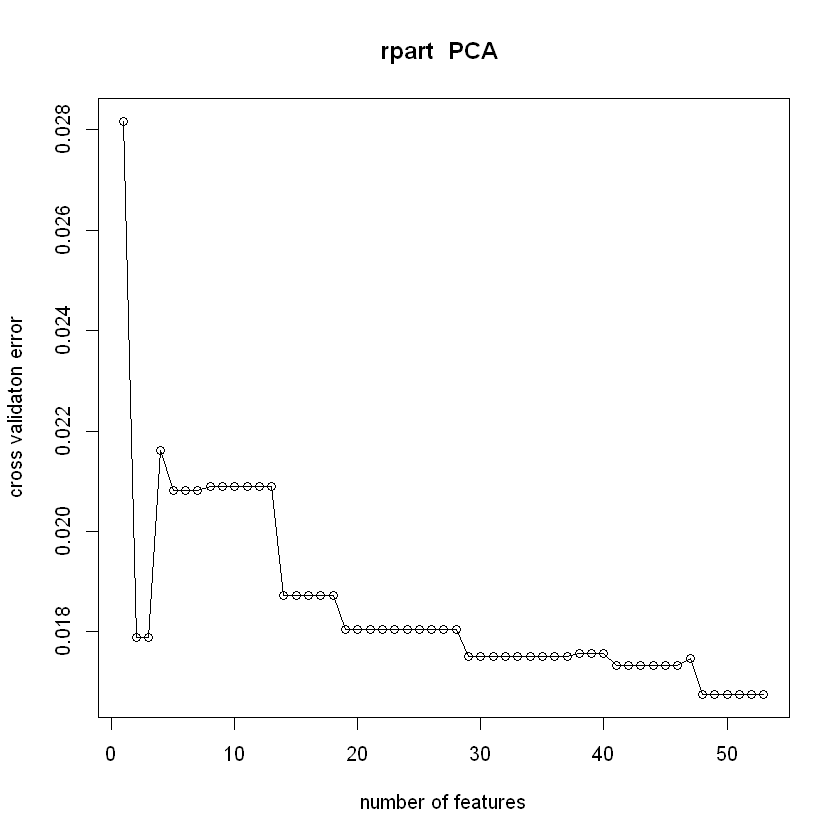

In [49]:
#pca('rpart', X, Y)# Features:  3  ; CV error= 0.0179  ; std dev= 0.0148

In [50]:
#forwardSelection('rpart', X, Y) #"Round  3  ; Selected feature:  45  ; CV error= 0.0118  ; std dev= 0.0091"

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0127  ; std dev= 0.0098"
[1] "Round  2  ; Selected feature:  14  ; CV error= 0.0119  ; std dev= 0.0093"
[1] "Round  3  ; Selected feature:  45  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  4  ; Selected feature:  1  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  5  ; Selected feature:  4  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  6  ; Selected feature:  7  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  7  ; Selected feature:  10  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  8  ; Selected feature:  11  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  9  ; Selected feature:  13  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  10  ; Selected feature:  15  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  11  ; Selected feature:  20  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  12  ; Selected feature:  21  ; CV error= 0.0118  ; std dev= 0.0091"
[1] "Round  13  ; Selected feature:  22  ; CV error= 

[1]  3 14 45  1  4  7 10 11 13 15 20 21 22 23 24 25 26 27 28 29 30 31 35 36 38
[26] 39 40 41 42 43 44 46 47 48 49 50 51 52 53  8 19 17 33  5  6 16 32 34 37 18
[51]  2 12  9

In [51]:
runEnsemble('rpart', X, Y)#0.0183  

[1] "Ensemble  rpart   CV error= 0.0183  ; std dev= 0.0098"


rpart Features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart Features:  2  ; CV error= 0.0127  ; std dev= 0.0098
rpart Features:  3  ; CV error= 0.0128  ; std dev= 0.0105
rpart Features:  4  ; CV error= 0.0139  ; std dev= 0.0101
rpart Features:  5  ; CV error= 0.0139  ; std dev= 0.0101
rpart Features:  6  ; CV error= 0.0153  ; std dev= 0.0086
rpart Features:  7  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  8  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  9  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  10  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  11  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  12  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  13  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  14  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  15  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  16  ; CV error= 0.0142  ; std dev= 0.0121
rpart Features:  17  ; CV error= 0.0142  ; std dev= 0.0121
rpart 

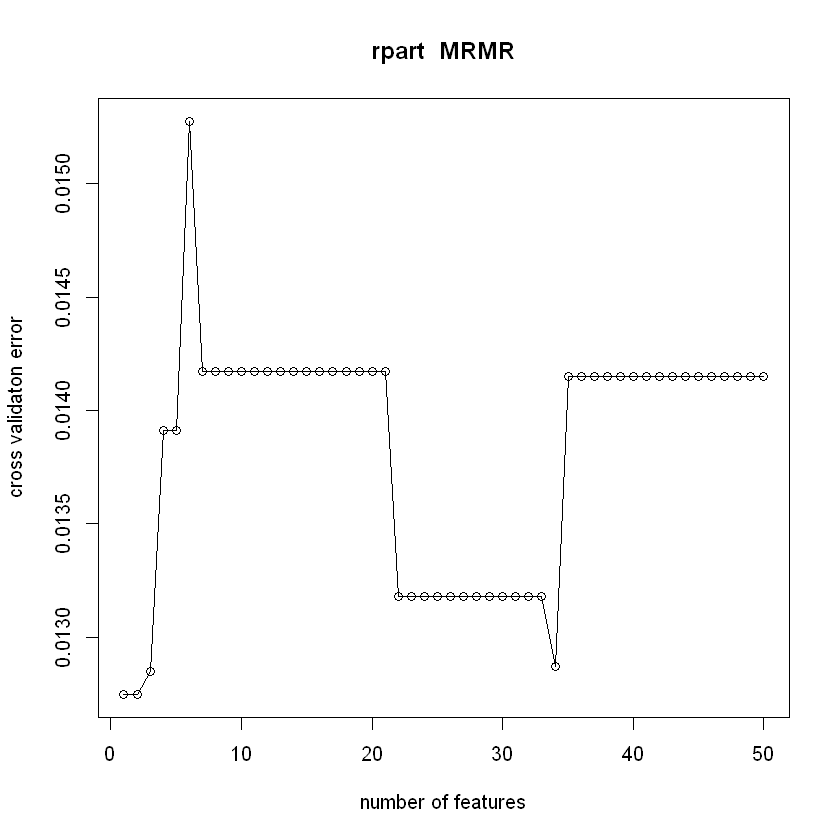

In [39]:
X<- data[1:nrow(input),]
#the winner is mrmr
rpartIndexes <- mrmr('rpart', X, Y) #34  ; CV error= 0.0129  ; std dev= 0.0109


In [40]:
rpartIndexes <- rpartIndexes[1:34]

In [126]:
runEnsemble('rpart', X[,rpartIndexes], Y) #0.0146  

[1] "Ensemble  rpart   CV error= 0.0146  ; std dev= 0.0092"


## SVM

In [201]:
X<- data[1:nrow(input),]
runModel('svm', X, Y, 2) #0.0144 #linear 0.0132 # radial 0.0137  

[1] "svm   CV error= 0.0132  ; std dev= 0.008"


svm  filter features:  1  ; CV error= 0.015  ; std dev= 0.0103
svm  filter features:  2  ; CV error= 0.0204  ; std dev= 0.013
svm  filter features:  3  ; CV error= 0.0175  ; std dev= 0.0095
svm  filter features:  4  ; CV error= 0.0173  ; std dev= 0.0097
svm  filter features:  5  ; CV error= 0.0149  ; std dev= 0.0088
svm  filter features:  6  ; CV error= 0.015  ; std dev= 0.009
svm  filter features:  7  ; CV error= 0.0145  ; std dev= 0.0089
svm  filter features:  8  ; CV error= 0.0135  ; std dev= 0.0091
svm  filter features:  9  ; CV error= 0.0119  ; std dev= 0.0072
svm  filter features:  10  ; CV error= 0.0121  ; std dev= 0.0076
svm  filter features:  11  ; CV error= 0.0135  ; std dev= 0.0078
svm  filter features:  12  ; CV error= 0.0127  ; std dev= 0.0098
svm  filter features:  13  ; CV error= 0.0141  ; std dev= 0.0097
svm  filter features:  14  ; CV error= 0.0126  ; std dev= 0.0082
svm  filter features:  15  ; CV error= 0.0125  ; std dev= 0.0074
svm  filter features:  16  ; CV error=

[1]  3  9 18 19  8 12  5  6 16 17  7 33 20 13 21 32 37  2 34 52 10 50 14 29 46
[26] 53 15 22 39 45 24 35 30 48 42 49 47 51  1 31 25 27 28  4 43 23 36 26 44 38
[51] 11 41 40

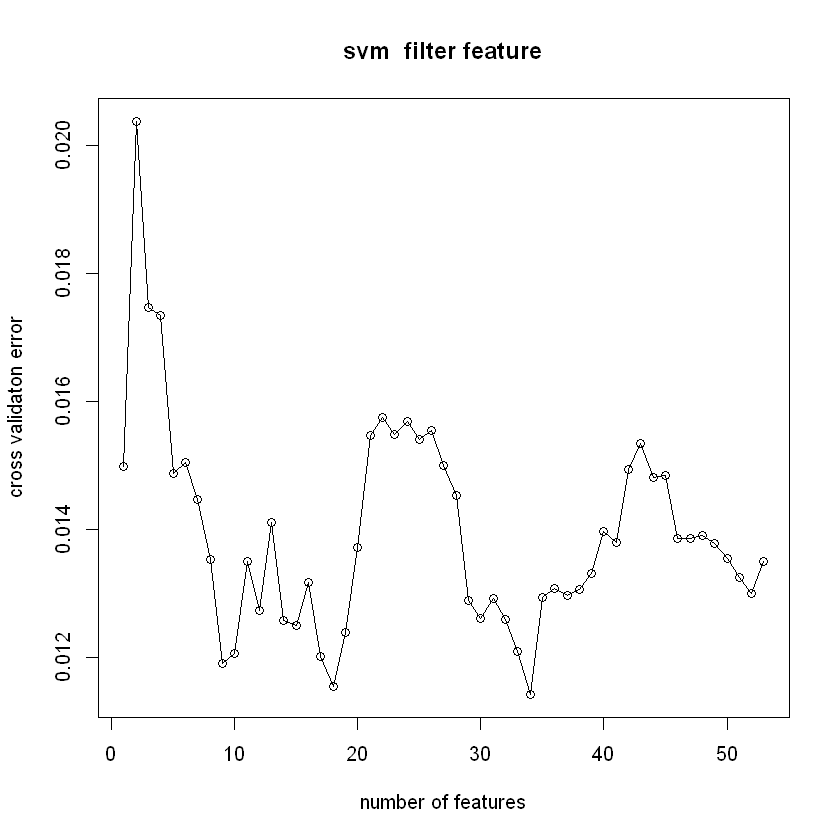

In [210]:
#outputCorrelation('svm', X, Y) #filter features:  15  ; CV error= 0.0129  ; std dev= 0.0084

In [ ]:
#mrmr('svm', X, Y) #svm Features:  19  ; CV error= 0.0131  ; std dev= 0.0084

In [ ]:
#pca('svm', X, Y) #

In [ ]:
runEnsemble('svm', X, Y)# # 0.0148

svm  filter features:  1  ; CV error= 0.0152  ; std dev= 0.0103
svm  filter features:  2  ; CV error= 0.0201  ; std dev= 0.0132
svm  filter features:  3  ; CV error= 0.0173  ; std dev= 0.0098
svm  filter features:  4  ; CV error= 0.0177  ; std dev= 0.0093
svm  filter features:  5  ; CV error= 0.0165  ; std dev= 0.009
svm  filter features:  6  ; CV error= 0.016  ; std dev= 0.0096
svm  filter features:  7  ; CV error= 0.0153  ; std dev= 0.0089
svm  filter features:  8  ; CV error= 0.015  ; std dev= 0.0103
svm  filter features:  9  ; CV error= 0.0143  ; std dev= 0.0074
svm  filter features:  10  ; CV error= 0.0141  ; std dev= 0.0072
svm  filter features:  11  ; CV error= 0.0142  ; std dev= 0.0077
svm  filter features:  12  ; CV error= 0.0147  ; std dev= 0.0075
svm  filter features:  13  ; CV error= 0.0146  ; std dev= 0.0066
svm  filter features:  14  ; CV error= 0.0136  ; std dev= 0.0076
svm  filter features:  15  ; CV error= 0.0129  ; std dev= 0.0084
svm  filter features:  16  ; CV error

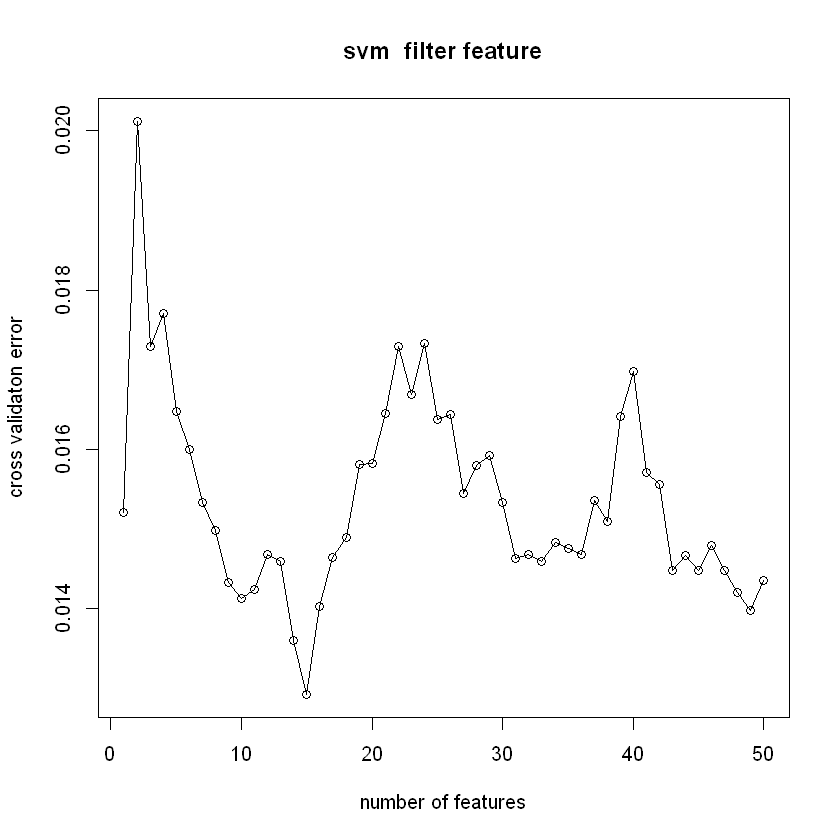

In [41]:
X<- data[1:nrow(input),]
svmIndexes <- outputCorrelation('svm', X, Y)

In [42]:
#the best rmse is given by forward selection
svmIndexes <- svmIndexes[1:15]



## LAZY


In [60]:
X<- numeric.df[1:nrow(input),] 
runModel('lazy', X, Y, 5) #0.0403  

[1] "lazy   CV error= 0.0403  ; std dev= 0.0455"


lazy  filter features:  1  ; CV error= 0.0161  ; std dev= 0.0112
lazy  filter features:  2  ; CV error= 0.0171  ; std dev= 0.0183
lazy  filter features:  3  ; CV error= 0.0123  ; std dev= 0.0065
lazy  filter features:  4  ; CV error= 0.0524  ; std dev= 0.041
lazy  filter features:  5  ; CV error= 0.066  ; std dev= 0.0564
lazy  filter features:  6  ; CV error= 0.0515  ; std dev= 0.0534
lazy  filter features:  7  ; CV error= 0.0411  ; std dev= 0.0431
lazy  filter features:  8  ; CV error= 0.0424  ; std dev= 0.0488
lazy  filter features:  9  ; CV error= 0.0343  ; std dev= 0.0427
lazy  filter features:  10  ; CV error= 0.0262  ; std dev= 0.0294
lazy  filter features:  11  ; CV error= 0.0158  ; std dev= 0.0093
lazy  filter features:  12  ; CV error= 0.0285  ; std dev= 0.0282
lazy  filter features:  13  ; CV error= 0.0258  ; std dev= 0.0291
lazy  filter features:  14  ; CV error= 0.0199  ; std dev= 0.0223
lazy  filter features:  15  ; CV error= 0.0116  ; std dev= 0.009
lazy  filter features:

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21  2 10 14 15 22 24  1 25 27 28  4
[26] 23 26 11

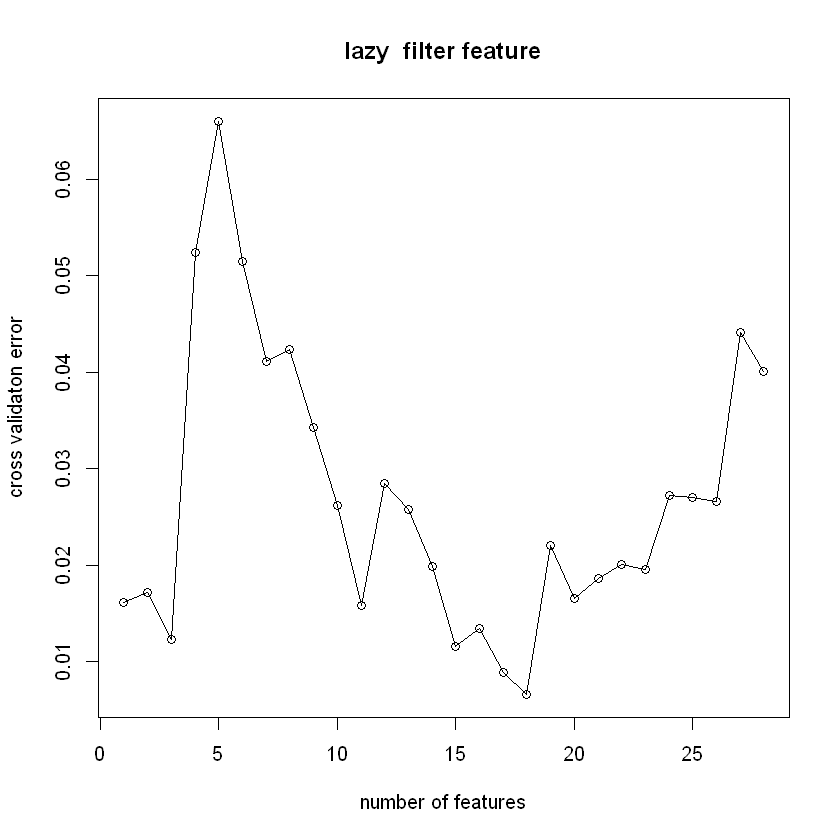

In [61]:
#outputCorrelation('lazy', X, Y)#18  ; CV error= 0.0066  ; std dev= 0.0057

lazy Features:  1  ; CV error= 0.0161  ; std dev= 0.0112
lazy Features:  2  ; CV error= 0.0218  ; std dev= 0.0148
lazy Features:  3  ; CV error= 0.0448  ; std dev= 0.0536
lazy Features:  4  ; CV error= 0.1069  ; std dev= 0.083
lazy Features:  5  ; CV error= 0.0751  ; std dev= 0.065
lazy Features:  6  ; CV error= 0.0775  ; std dev= 0.0772
lazy Features:  7  ; CV error= 0.0991  ; std dev= 0.074
lazy Features:  8  ; CV error= 0.0866  ; std dev= 0.074
lazy Features:  9  ; CV error= 0.0836  ; std dev= 0.0546
lazy Features:  10  ; CV error= 0.0646  ; std dev= 0.049
lazy Features:  11  ; CV error= 0.065  ; std dev= 0.0562
lazy Features:  12  ; CV error= 0.0617  ; std dev= 0.052
lazy Features:  13  ; CV error= 0.0343  ; std dev= 0.0281
lazy Features:  14  ; CV error= 0.0364  ; std dev= 0.0462
lazy Features:  15  ; CV error= 0.0454  ; std dev= 0.0394
lazy Features:  16  ; CV error= 0.039  ; std dev= 0.0334
lazy Features:  17  ; CV error= 0.0337  ; std dev= 0.0349
lazy Features:  18  ; CV error=

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

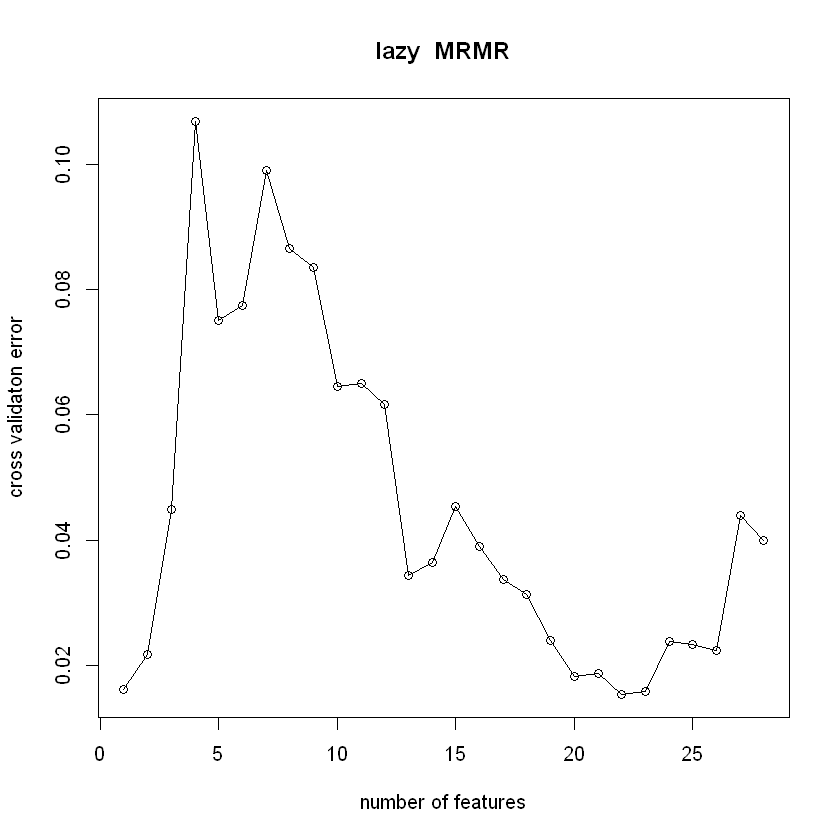

In [62]:
#mrmr('lazy', X, Y)#22  ; CV error= 0.0153  ; std dev= 0.0096

lazy  Features:  1  ; CV error= 0.0345  ; std dev= 0.0216
lazy  Features:  2  ; CV error= 0.0181  ; std dev= 0.0175
lazy  Features:  3  ; CV error= 0.0229  ; std dev= 0.0188
lazy  Features:  4  ; CV error= 0.0805  ; std dev= 0.1176
lazy  Features:  5  ; CV error= 0.0935  ; std dev= 0.1555
lazy  Features:  6  ; CV error= 0.2507  ; std dev= 0.3708
lazy  Features:  7  ; CV error= 0.1969  ; std dev= 0.3504
lazy  Features:  8  ; CV error= 0.1019  ; std dev= 0.1975
lazy  Features:  9  ; CV error= 0.0442  ; std dev= 0.0722
lazy  Features:  10  ; CV error= 0.0564  ; std dev= 0.0617
lazy  Features:  11  ; CV error= 0.1744  ; std dev= 0.4101
lazy  Features:  12  ; CV error= 0.2716  ; std dev= 0.4128
lazy  Features:  13  ; CV error= 0.1661  ; std dev= 0.1818
lazy  Features:  14  ; CV error= 0.0902  ; std dev= 0.0781
lazy  Features:  15  ; CV error= 0.0991  ; std dev= 0.1064
lazy  Features:  16  ; CV error= 0.0531  ; std dev= 0.0591
lazy  Features:  17  ; CV error= 0.0912  ; std dev= 0.1178
lazy  

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
-2065.8900,113.85792,24.586513,263.0594,114.39025,-35.967129,-98.251314,-22.2560031,8.990474,-33.5365523,...,0.26268057,-0.32928352,-0.085160242,-0.808687722,-0.58202540,-0.15388255,-0.06789207,-0.28058861,-0.147156777,0.091651860
-917.7324,-80.56675,56.802650,-311.9055,-49.13928,79.873186,212.212160,25.3229159,27.979274,-0.4423117,...,2.30582469,0.75705743,0.161850748,0.534085294,0.85509626,-0.09937444,-0.32991551,-0.06858620,-0.807748581,-0.044661437
735.5653,164.30915,26.020406,255.8353,121.88086,22.539030,-108.322870,-3.6573112,25.796962,-35.5229479,...,-0.86127232,0.18791607,-0.136872700,0.371886289,-0.71567372,-0.18235727,0.07821528,-0.39044196,-0.074871819,-0.059361191
-967.1986,32.43104,29.024820,356.4721,99.80322,180.994055,-119.487512,181.4764056,-150.502830,69.9779698,...,-0.56776510,-1.69592686,-0.383220813,0.170613523,-0.72926330,-0.46643076,-0.58519234,0.72619215,-0.004393291,0.029657255
3755.0246,646.20113,-4.414097,287.3848,299.36128,-12.543443,34.891324,-6.8893584,-6.894942,-19.3498927,...,0.42096196,-0.37434265,-0.173959806,0.042741958,-0.76939988,-0.04997115,-0.02258472,0.01591037,0.002187477,0.068953123
3593.3691,-396.23305,-623.857989,113.0340,49.45887,84.884165,-45.015105,-12.0040570,28.844119,-43.2803400,...,-1.77360956,0.85383511,-0.636470994,-1.251402299,-0.32454363,0.45562594,-0.25305965,0.16654138,0.051618656,0.003685003
-421.9633,547.43326,12.800807,-428.3266,17.68638,18.335204,127.213571,4.5786859,1.564227,-12.3106668,...,0.09683866,-0.67060324,0.012558059,0.113361018,-0.27794267,-0.50503013,0.33581921,-0.14752898,-0.003109245,-0.059801635
-125.0050,497.46385,-354.835634,278.4744,-24.62461,-89.219890,102.538322,34.1770727,-241.090290,64.8888847,...,0.34506098,0.54719755,-0.855262469,0.457111901,-0.11863785,-0.19985576,-0.32178093,-0.21113661,-0.006865037,-0.052631585
-4394.0278,212.66759,10.000079,235.3965,-87.98918,96.138450,-9.910449,161.3964922,-82.917976,49.5539440,...,0.20057404,-1.94790289,-1.175946087,-0.159436643,1.21635374,-0.42129946,-0.26656346,-0.23538997,-0.052927745,-0.851166181
-3104.7676,-404.87516,72.281198,-169.3016,-195.33952,-60.925290,-45.907632,-2.9117863,35.995338,-31.7200229,...,0.47553911,-0.22807586,-1.421993519,0.727462660,0.13871272,-0.43802030,-0.03545600,0.03817294,0.070149705,-0.780883386


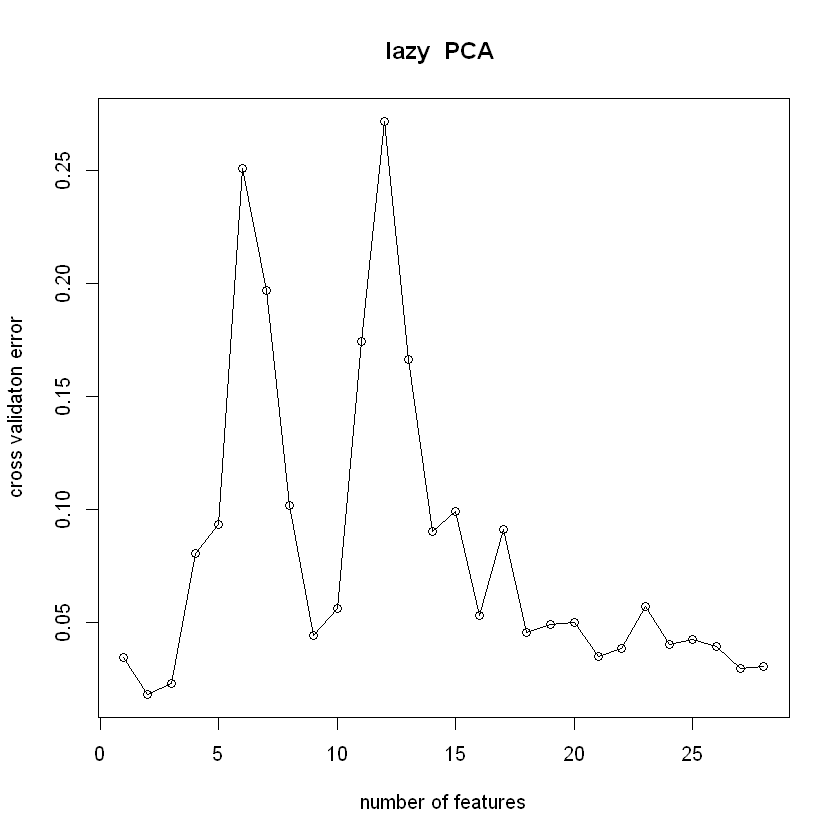

In [63]:
#pca('lazy', X, Y)#Features:  2  ; CV error= 0.0181  ; std dev= 0.0175

In [64]:
#forwardSelection('lazy', X, Y) #2  ; Selected feature:  13  ; CV error= 0.0102  ; std dev= 0.0081"

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0161  ; std dev= 0.0112"
[1] "Round  2  ; Selected feature:  13  ; CV error= 0.0102  ; std dev= 0.0081"
[1] "Round  3  ; Selected feature:  15  ; CV error= 0.0174  ; std dev= 0.0158"
[1] "Round  4  ; Selected feature:  24  ; CV error= 0.0259  ; std dev= 0.0155"
[1] "Round  5  ; Selected feature:  28  ; CV error= 0.0297  ; std dev= 0.026"
[1] "Round  6  ; Selected feature:  27  ; CV error= 0.0147  ; std dev= 0.0135"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.0146  ; std dev= 0.0131"
[1] "Round  8  ; Selected feature:  25  ; CV error= 0.0188  ; std dev= 0.0137"
[1] "Round  9  ; Selected feature:  17  ; CV error= 0.0236  ; std dev= 0.0112"
[1] "Round  10  ; Selected feature:  12  ; CV error= 0.0189  ; std dev= 0.0159"
[1] "Round  11  ; Selected feature:  6  ; CV error= 0.0198  ; std dev= 0.0142"
[1] "Round  12  ; Selected feature:  14  ; CV error= 0.0199  ; std dev= 0.0152"
[1] "Round  13  ; Selected feature:  10  ; CV error=

[1]  3 13 15 24 28 27 11 25 17 12  6 14 10 16 18 26 23  4  1 21 22  7  5  9 20
[26] 19  2  8

In [65]:
#runEnsemble('lazy', X, Y)

[1] "Ensemble  lazy   CV error= 0.1037  ; std dev= 0.0606"


lazy  filter features:  1  ; CV error= 0.0161  ; std dev= 0.0112
lazy  filter features:  2  ; CV error= 0.0171  ; std dev= 0.0183
lazy  filter features:  3  ; CV error= 0.0123  ; std dev= 0.0065
lazy  filter features:  4  ; CV error= 0.0524  ; std dev= 0.041
lazy  filter features:  5  ; CV error= 0.066  ; std dev= 0.0564
lazy  filter features:  6  ; CV error= 0.0515  ; std dev= 0.0534
lazy  filter features:  7  ; CV error= 0.0411  ; std dev= 0.0431
lazy  filter features:  8  ; CV error= 0.0424  ; std dev= 0.0488
lazy  filter features:  9  ; CV error= 0.0343  ; std dev= 0.0427
lazy  filter features:  10  ; CV error= 0.0262  ; std dev= 0.0294
lazy  filter features:  11  ; CV error= 0.0158  ; std dev= 0.0093
lazy  filter features:  12  ; CV error= 0.0285  ; std dev= 0.0282
lazy  filter features:  13  ; CV error= 0.0258  ; std dev= 0.0291
lazy  filter features:  14  ; CV error= 0.0199  ; std dev= 0.0223
lazy  filter features:  15  ; CV error= 0.0116  ; std dev= 0.009
lazy  filter features:

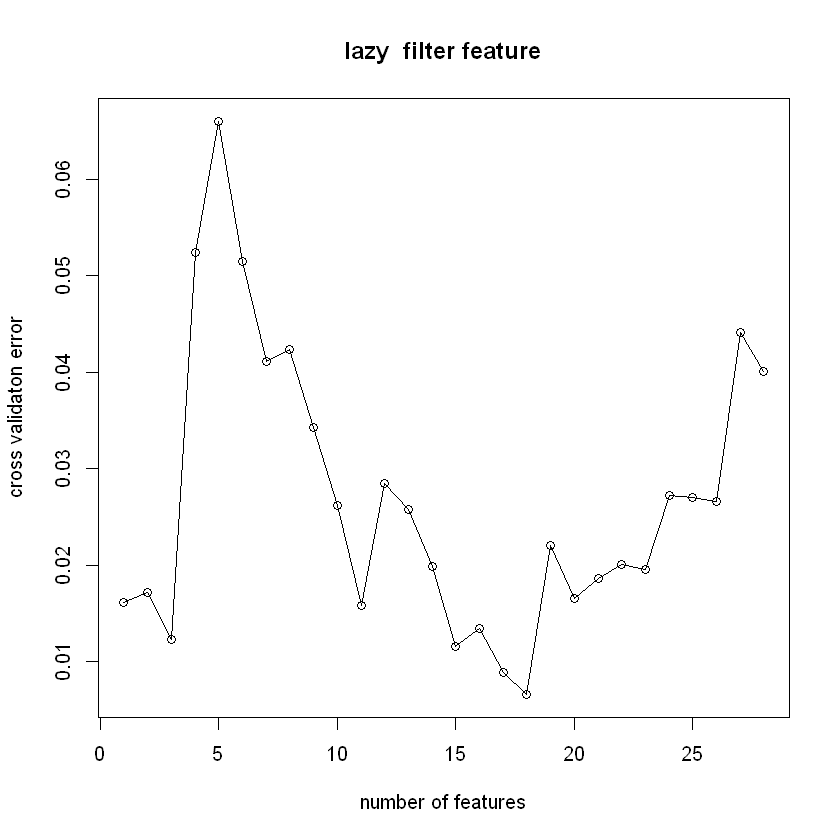

In [43]:
X<- numeric.df[1:nrow(input),]
#the winner is
lazyIndexes<- outputCorrelation('lazy', X, Y)


In [44]:
lazyIndexes <- lazyIndexes[1:18]

## TREE

In [68]:
X<- data[1:nrow(input),]
runModel('tree', X, Y, 5)

[1] "tree   CV error= 0.0139  ; std dev= 0.011"


tree  filter features:  1  ; CV error= 0.0125  ; std dev= 0.0093
tree  filter features:  2  ; CV error= 0.0162  ; std dev= 0.0101
tree  filter features:  3  ; CV error= 0.0139  ; std dev= 0.0101
tree  filter features:  4  ; CV error= 0.0133  ; std dev= 0.0101
tree  filter features:  5  ; CV error= 0.0141  ; std dev= 0.0117
tree  filter features:  6  ; CV error= 0.0146  ; std dev= 0.0111
tree  filter features:  7  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  8  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  9  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  10  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  11  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  12  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter features:  13  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter features:  14  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter features:  15  ; CV error= 0.0139  ; std dev= 0.0122
tree  filter featur

[1]  3  9 18 19  8 12  5  6 16 17  7 33 20 13 21 32 37  2 34 52 10 50 14 29 46
[26] 53 15 22 39 45 24 35 30 48 42 49 47 51  1 31 25 27 28  4 43 23 36 26 44 38
[51] 11 41 40

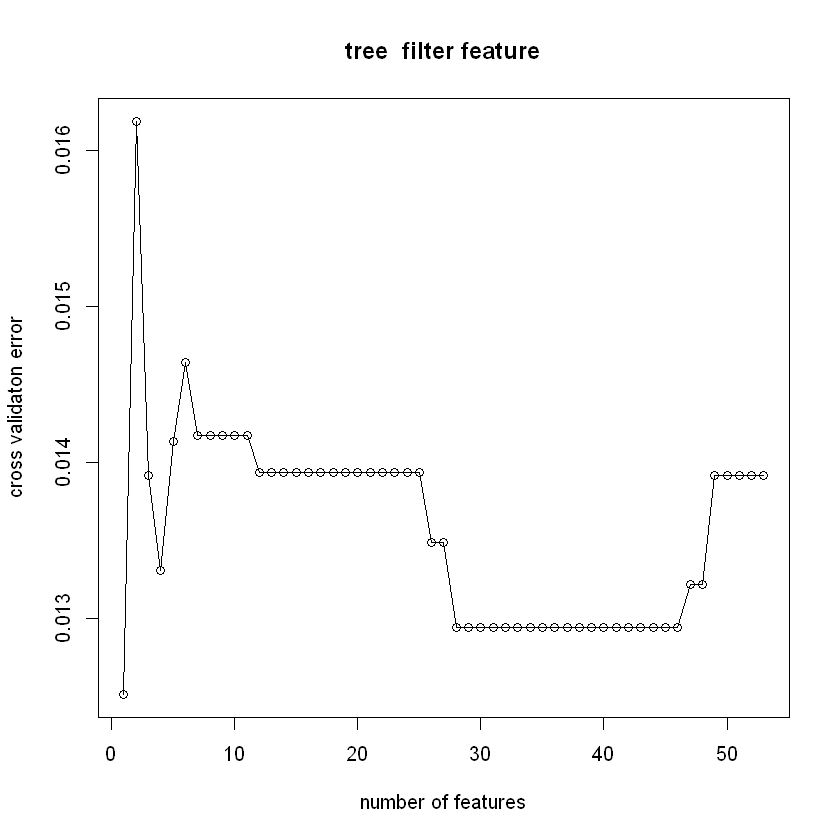

In [69]:
#outputCorrelation('tree', X, Y) #28  ; CV error= 0.0129  ; std dev= 0.0115

tree Features:  1  ; CV error= 0.0125  ; std dev= 0.0093
tree Features:  2  ; CV error= 0.0137  ; std dev= 0.0107
tree Features:  3  ; CV error= 0.0137  ; std dev= 0.0107
tree Features:  4  ; CV error= 0.017  ; std dev= 0.0111
tree Features:  5  ; CV error= 0.0129  ; std dev= 0.0097
tree Features:  6  ; CV error= 0.0129  ; std dev= 0.0097
tree Features:  7  ; CV error= 0.0147  ; std dev= 0.0085
tree Features:  8  ; CV error= 0.0138  ; std dev= 0.0123
tree Features:  9  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  10  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  11  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  12  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  13  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  14  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  15  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  16  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  17  ; CV error= 0.0139  ; std dev= 0.0122
tree Features:  18  ; CV

[1]  3 33 32  9 18 37  5  8  6 52 19 12 17 50 16 46  7 29 20 13 34 53 21 22  2
[26] 15 10 45 14 30 39 42 24 48 35 49 31  4 51 47  1 28 27 25 43 26 23 38 44 36
[51] 11 40 41

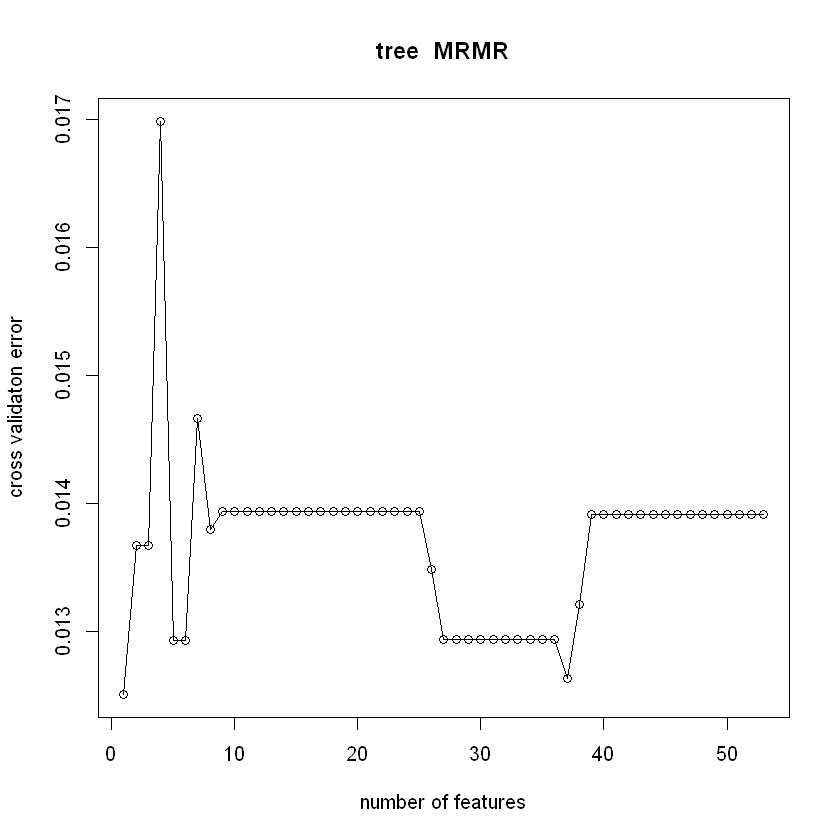

In [71]:
#mrmr('tree', X, Y)#4  ; CV error= 0.017  ; std dev= 0.0111

tree  Features:  1  ; CV error= 0.0282  ; std dev= 0.0156
tree  Features:  2  ; CV error= 0.0178  ; std dev= 0.0151
tree  Features:  3  ; CV error= 0.0178  ; std dev= 0.0151
tree  Features:  4  ; CV error= 0.0204  ; std dev= 0.0132
tree  Features:  5  ; CV error= 0.0196  ; std dev= 0.0123
tree  Features:  6  ; CV error= 0.0196  ; std dev= 0.0123
tree  Features:  7  ; CV error= 0.0196  ; std dev= 0.0123
tree  Features:  8  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  9  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  10  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  11  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  12  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  13  ; CV error= 0.0197  ; std dev= 0.0122
tree  Features:  14  ; CV error= 0.0171  ; std dev= 0.0118
tree  Features:  15  ; CV error= 0.0171  ; std dev= 0.0118
tree  Features:  16  ; CV error= 0.0171  ; std dev= 0.0118
tree  Features:  17  ; CV error= 0.0171  ; std dev= 0.0118
tree  

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
-2065.8900,113.85787,24.586562,-263.05927,114.39034,-35.966998,98.251314,-22.2563486,8.991420,-33.5371991,...,-0.0361186178,-0.0134996699,-9.637035e-03,0.0158178409,0.010479243,0.0031713373,5.108912e-04,-1.800349e-15,9.852897e-15,4.226643e-15
-917.7324,-80.56677,56.802655,311.90552,-49.13922,79.873217,-212.211965,25.3229535,27.978980,-0.4423982,...,-0.0039664524,0.0791592561,-2.282335e-02,-0.0398591567,-0.021293703,0.0286470766,1.690550e-03,1.283989e-15,-1.439854e-14,-7.493149e-15
735.5653,164.30935,26.020367,-255.83505,121.88118,22.539234,108.322183,-3.6583613,25.798515,-35.5233323,...,0.0045835397,-0.0580196644,5.865202e-03,-0.0125646599,-0.002658810,-0.0040963616,3.305640e-03,-5.235930e-16,1.201783e-14,7.585068e-15
-967.1986,32.43131,29.024743,-356.47212,99.80338,180.994124,119.487181,181.4772171,-150.501842,69.9773916,...,-0.0101627556,0.0071614580,-3.748023e-02,-0.0896736628,-0.045738711,0.0030905821,-1.337442e-02,-2.601792e-15,2.751585e-14,2.265808e-14
3755.0246,646.20132,-4.414132,-287.38469,299.36149,-12.543487,-34.891756,-6.8897716,-6.894603,-19.3498569,...,-0.0060990404,-0.0449619854,-2.159463e-02,-0.0148031662,-0.010836986,0.0264627954,5.392760e-05,-5.127549e-15,1.893985e-15,1.954078e-14
3593.3691,-396.23283,-623.858069,-113.03379,49.45908,84.884211,45.014513,-12.0048528,28.845527,-43.2800847,...,0.0192001239,0.0159190477,-8.827009e-03,0.0557699450,-0.007157297,-0.0152493567,6.511404e-03,-1.433199e-14,7.091217e-15,7.883440e-15
-421.9633,547.43320,12.800868,428.32662,17.68625,18.335130,-127.213224,4.5789904,1.564307,-12.3107439,...,0.0081930929,0.0374832895,1.270482e-02,-0.0061500440,0.019783448,0.0109424068,-2.571335e-04,2.951965e-16,-1.487732e-14,1.499658e-15
-125.0050,497.46410,-354.835677,-278.47439,-24.62442,-89.219739,-102.538710,34.1781467,-241.090180,64.8879603,...,0.0273057340,-0.0173733275,-2.855771e-02,-0.0147581561,-0.010837674,-0.0075147045,3.196137e-03,-1.291993e-14,-4.573064e-15,2.720132e-14
-4394.0278,212.66731,10.000148,-235.39678,-87.98945,96.138218,9.911098,161.3974038,-82.918799,49.5532325,...,-0.0187958953,0.0217793466,-1.187100e-02,-0.0581329208,0.033768174,0.0037513011,7.361961e-03,-4.756318e-15,1.122680e-14,1.604358e-14
-3104.7676,-404.87518,72.281191,169.30152,-195.33960,-60.925170,45.907805,-2.9113422,35.994159,-31.7192467,...,0.0060958750,0.0866370437,-1.193311e-02,-0.0340776683,-0.047939500,0.0174911680,3.136707e-03,1.352073e-14,-6.307787e-15,-1.924243e-14


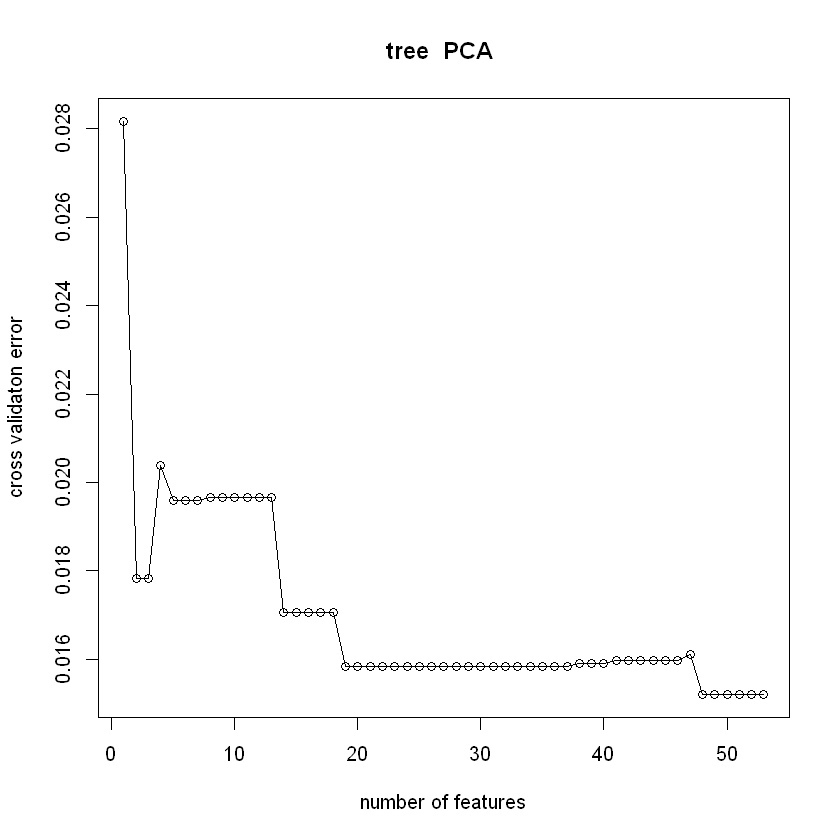

In [72]:
#pca('tree', X, Y)#48  ; CV error= 0.0152  ; std dev= 0.013

In [73]:
#forwardSelection('tree', X, Y) #44  ; Selected feature:  17  ; CV error= 0.0097  ; std dev= 0.009"

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0125  ; std dev= 0.0093"
[1] "Round  2  ; Selected feature:  14  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  3  ; Selected feature:  1  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  4  ; Selected feature:  4  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  5  ; Selected feature:  7  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  6  ; Selected feature:  10  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  8  ; Selected feature:  13  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  9  ; Selected feature:  15  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  10  ; Selected feature:  20  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  11  ; Selected feature:  21  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  12  ; Selected feature:  22  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  13  ; Selected feature:  23  ; CV error= 

[1]  3 14  1  4  7 10 11 13 15 20 21 22 23 24 25 26 27 28 29 30 31 35 36 38 39
[26] 40 41 42 43 44 46 47 48 49 50 51 52 53 45  6 34 18  8 17  5 16 32 37 33  2
[51] 19 12  9

In [75]:
#runEnsemble('tree', X, Y)

[1] "Ensemble  tree   CV error= 0.0156  ; std dev= 0.0102"


In [45]:
X<- numeric.df[1:nrow(input),] 
treeIndexes <-forwardSelection('tree', X, Y)


[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0125  ; std dev= 0.0093"
[1] "Round  2  ; Selected feature:  14  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  3  ; Selected feature:  1  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  4  ; Selected feature:  4  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  5  ; Selected feature:  7  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  6  ; Selected feature:  10  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  8  ; Selected feature:  13  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  9  ; Selected feature:  15  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  10  ; Selected feature:  20  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  11  ; Selected feature:  21  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  12  ; Selected feature:  22  ; CV error= 0.0116  ; std dev= 0.0088"
[1] "Round  13  ; Selected feature:  23  ; CV error= 

In [46]:
treeIndexes <- treeIndexes[1:22]

In [79]:
#runEnsemble('tree', X[, treeIndexes], Y)

[1] "Ensemble  tree   CV error= 0.0145  ; std dev= 0.0103"


## LM

In [216]:
X<- numeric.df[1:nrow(input),]
runModel('lm', X, Y, 10) #0.0095  

[1] "lm   CV error= 0.0095  ; std dev= 0.0066"


lm  filter features:  1  ; CV error= 0.0103  ; std dev= 0.0083
lm  filter features:  2  ; CV error= 0.0085  ; std dev= 0.0071
lm  filter features:  3  ; CV error= 0.0093  ; std dev= 0.0065
lm  filter features:  4  ; CV error= 0.0089  ; std dev= 0.0059
lm  filter features:  5  ; CV error= 0.0092  ; std dev= 0.0076
lm  filter features:  6  ; CV error= 0.0087  ; std dev= 0.0082
lm  filter features:  7  ; CV error= 0.0083  ; std dev= 0.0073
lm  filter features:  8  ; CV error= 0.0083  ; std dev= 0.0078
lm  filter features:  9  ; CV error= 0.0084  ; std dev= 0.008
lm  filter features:  10  ; CV error= 0.0106  ; std dev= 0.0075
lm  filter features:  11  ; CV error= 0.0105  ; std dev= 0.0075
lm  filter features:  12  ; CV error= 0.0102  ; std dev= 0.0067
lm  filter features:  13  ; CV error= 0.01  ; std dev= 0.0067
lm  filter features:  14  ; CV error= 0.01  ; std dev= 0.0066
lm  filter features:  15  ; CV error= 0.0103  ; std dev= 0.0067
lm  filter features:  16  ; CV error= 0.0115  ; std de

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21  2 10 14 15 22 24  1 25 27 28  4
[26] 23 26 11

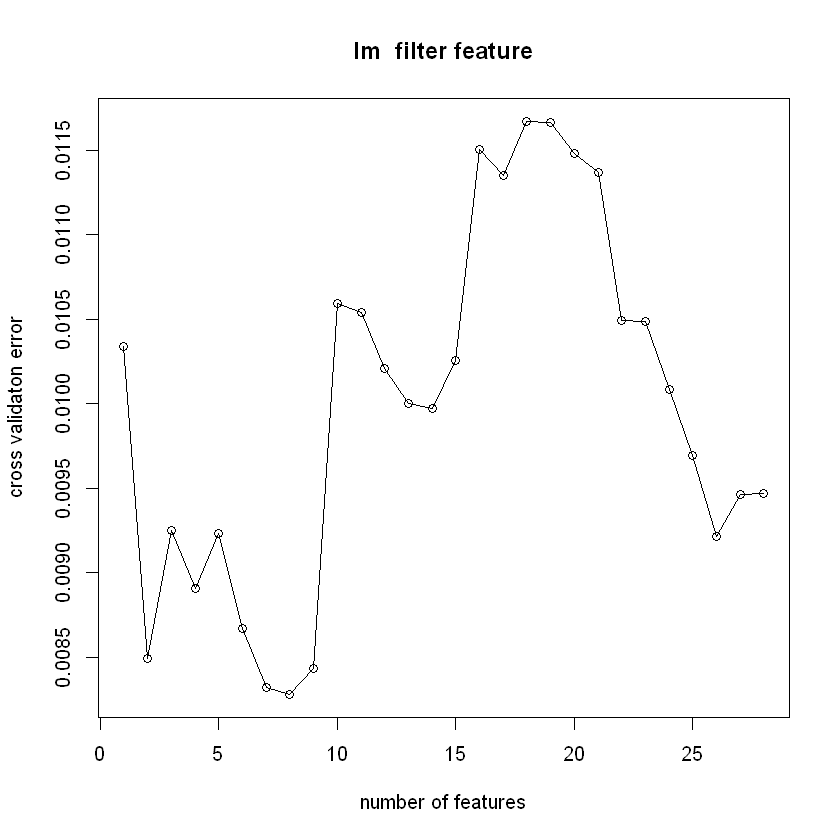

In [169]:
#outputCorrelation('lm', X, Y) # 7  ; CV error= 0.0083  ; std dev= 0.0073

lm Features:  1  ; CV error= 0.0103  ; std dev= 0.0083
lm Features:  2  ; CV error= 0.0102  ; std dev= 0.0084
lm Features:  3  ; CV error= 0.0105  ; std dev= 0.0068
lm Features:  4  ; CV error= 0.0093  ; std dev= 0.0062
lm Features:  5  ; CV error= 0.0083  ; std dev= 0.0063
lm Features:  6  ; CV error= 0.0079  ; std dev= 0.0053
lm Features:  7  ; CV error= 0.0073  ; std dev= 0.0058
lm Features:  8  ; CV error= 0.0078  ; std dev= 0.0067
lm Features:  9  ; CV error= 0.0096  ; std dev= 0.0073
lm Features:  10  ; CV error= 0.0101  ; std dev= 0.0072
lm Features:  11  ; CV error= 0.01  ; std dev= 0.0074
lm Features:  12  ; CV error= 0.0107  ; std dev= 0.007
lm Features:  13  ; CV error= 0.01  ; std dev= 0.007
lm Features:  14  ; CV error= 0.0101  ; std dev= 0.0063
lm Features:  15  ; CV error= 0.0102  ; std dev= 0.0063
lm Features:  16  ; CV error= 0.0116  ; std dev= 0.0073
lm Features:  17  ; CV error= 0.0116  ; std dev= 0.0073
lm Features:  18  ; CV error= 0.0116  ; std dev= 0.0085
lm Feat

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

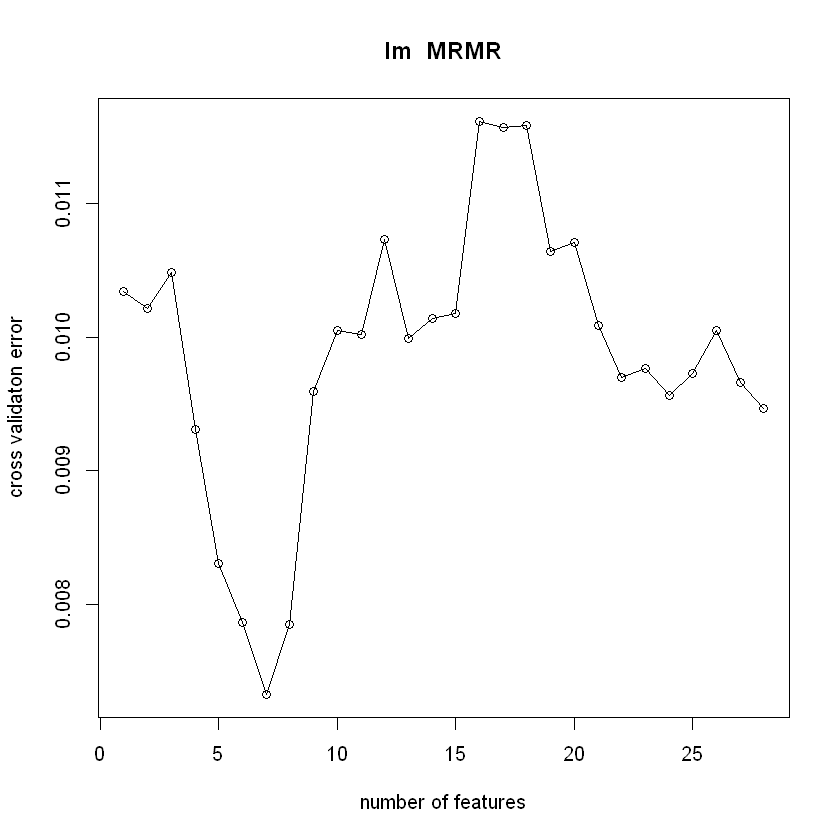

In [171]:
mrmr('lm', X, Y)#7  ; CV error= 0.0073  ; std dev= 0.0058

lm  Features:  1  ; CV error= 0.0273  ; std dev= 0.015
lm  Features:  2  ; CV error= 0.0148  ; std dev= 0.0144
lm  Features:  3  ; CV error= 0.0152  ; std dev= 0.0145
lm  Features:  4  ; CV error= 0.0154  ; std dev= 0.0146
lm  Features:  5  ; CV error= 0.0139  ; std dev= 0.0107
lm  Features:  6  ; CV error= 0.0143  ; std dev= 0.0105
lm  Features:  7  ; CV error= 0.0135  ; std dev= 0.0098
lm  Features:  8  ; CV error= 0.0128  ; std dev= 0.0097
lm  Features:  9  ; CV error= 0.0131  ; std dev= 0.0102
lm  Features:  10  ; CV error= 0.0131  ; std dev= 0.0102
lm  Features:  11  ; CV error= 0.0132  ; std dev= 0.0101
lm  Features:  12  ; CV error= 0.0127  ; std dev= 0.0105
lm  Features:  13  ; CV error= 0.0125  ; std dev= 0.0094
lm  Features:  14  ; CV error= 0.0089  ; std dev= 0.0074
lm  Features:  15  ; CV error= 0.009  ; std dev= 0.0074
lm  Features:  16  ; CV error= 0.0091  ; std dev= 0.0077
lm  Features:  17  ; CV error= 0.0091  ; std dev= 0.0079
lm  Features:  18  ; CV error= 0.0085  ; s

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
-2065.8900,113.85792,24.586513,263.0594,114.39025,-35.967129,-98.251314,-22.2560031,8.990474,-33.5365523,...,0.26268057,-0.32928352,-0.085160242,-0.808687722,-0.58202540,-0.15388255,-0.06789207,-0.28058861,-0.147156777,0.091651860
-917.7324,-80.56675,56.802650,-311.9055,-49.13928,79.873186,212.212160,25.3229159,27.979274,-0.4423117,...,2.30582469,0.75705743,0.161850748,0.534085294,0.85509626,-0.09937444,-0.32991551,-0.06858620,-0.807748581,-0.044661437
735.5653,164.30915,26.020406,255.8353,121.88086,22.539030,-108.322870,-3.6573112,25.796962,-35.5229479,...,-0.86127232,0.18791607,-0.136872700,0.371886289,-0.71567372,-0.18235727,0.07821528,-0.39044196,-0.074871819,-0.059361191
-967.1986,32.43104,29.024820,356.4721,99.80322,180.994055,-119.487512,181.4764056,-150.502830,69.9779698,...,-0.56776510,-1.69592686,-0.383220813,0.170613523,-0.72926330,-0.46643076,-0.58519234,0.72619215,-0.004393291,0.029657255
3755.0246,646.20113,-4.414097,287.3848,299.36128,-12.543443,34.891324,-6.8893584,-6.894942,-19.3498927,...,0.42096196,-0.37434265,-0.173959806,0.042741958,-0.76939988,-0.04997115,-0.02258472,0.01591037,0.002187477,0.068953123
3593.3691,-396.23305,-623.857989,113.0340,49.45887,84.884165,-45.015105,-12.0040570,28.844119,-43.2803400,...,-1.77360956,0.85383511,-0.636470994,-1.251402299,-0.32454363,0.45562594,-0.25305965,0.16654138,0.051618656,0.003685003
-421.9633,547.43326,12.800807,-428.3266,17.68638,18.335204,127.213571,4.5786859,1.564227,-12.3106668,...,0.09683866,-0.67060324,0.012558059,0.113361018,-0.27794267,-0.50503013,0.33581921,-0.14752898,-0.003109245,-0.059801635
-125.0050,497.46385,-354.835634,278.4744,-24.62461,-89.219890,102.538322,34.1770727,-241.090290,64.8888847,...,0.34506098,0.54719755,-0.855262469,0.457111901,-0.11863785,-0.19985576,-0.32178093,-0.21113661,-0.006865037,-0.052631585
-4394.0278,212.66759,10.000079,235.3965,-87.98918,96.138450,-9.910449,161.3964922,-82.917976,49.5539440,...,0.20057404,-1.94790289,-1.175946087,-0.159436643,1.21635374,-0.42129946,-0.26656346,-0.23538997,-0.052927745,-0.851166181
-3104.7676,-404.87516,72.281198,-169.3016,-195.33952,-60.925290,-45.907632,-2.9117863,35.995338,-31.7200229,...,0.47553911,-0.22807586,-1.421993519,0.727462660,0.13871272,-0.43802030,-0.03545600,0.03817294,0.070149705,-0.780883386


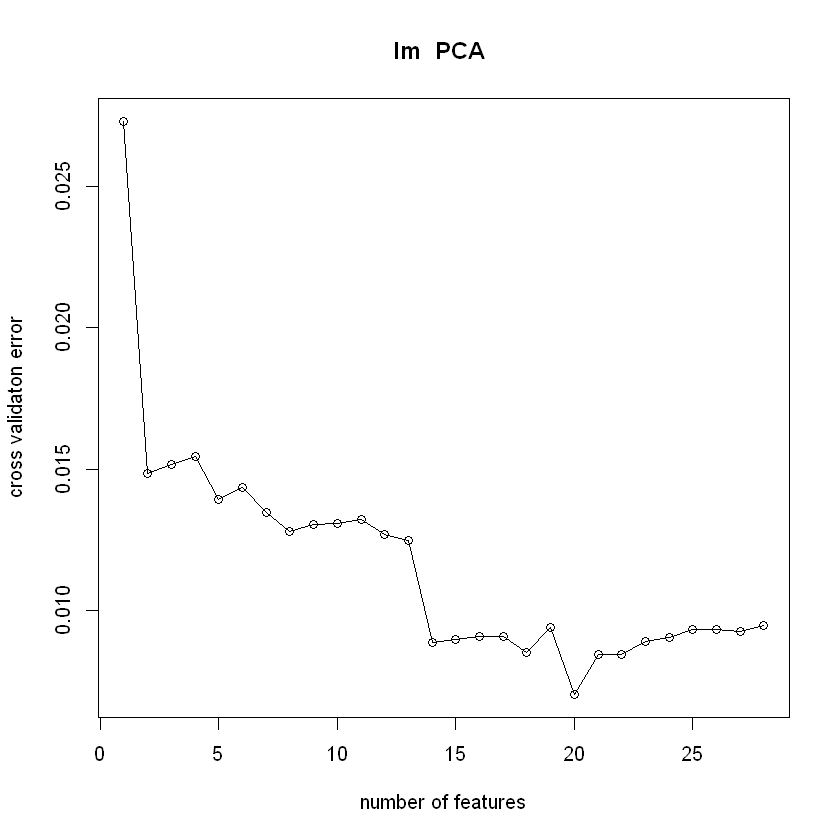

In [172]:
pca('lm', X, Y) #20  ; CV error= 0.007  ; std dev= 0.0062

In [173]:
forwardSelection('lm', X, Y)#7  ; CV error= 0.0047  ; std dev= 0.0063"

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0103  ; std dev= 0.0083"
[1] "Round  2  ; Selected feature:  9  ; CV error= 0.0085  ; std dev= 0.0071"
[1] "Round  3  ; Selected feature:  5  ; CV error= 0.0069  ; std dev= 0.0066"
[1] "Round  4  ; Selected feature:  20  ; CV error= 0.0061  ; std dev= 0.0056"
[1] "Round  5  ; Selected feature:  23  ; CV error= 0.0052  ; std dev= 0.0062"
[1] "Round  6  ; Selected feature:  25  ; CV error= 0.0051  ; std dev= 0.0066"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.005  ; std dev= 0.0072"
[1] "Round  8  ; Selected feature:  26  ; CV error= 0.0049  ; std dev= 0.0072"
[1] "Round  9  ; Selected feature:  27  ; CV error= 0.0049  ; std dev= 0.0072"
[1] "Round  10  ; Selected feature:  22  ; CV error= 0.0048  ; std dev= 0.0072"
[1] "Round  11  ; Selected feature:  24  ; CV error= 0.0048  ; std dev= 0.0062"
[1] "Round  12  ; Selected feature:  7  ; CV error= 0.0047  ; std dev= 0.0063"
[1] "Round  13  ; Selected feature:  14  ; CV error= 0

[1]  3  9  5 20 23 25 11 26 27 22 24  7 14 16 12 21 28 13 19  1  8  2 18  6  4
[26] 15 17 10

In [174]:
runEnsemble('lm', X, Y)#0.0103  

[1] "Ensemble  lm   CV error= 0.0103  ; std dev= 0.0062"


In [47]:
X<- data[1:nrow(input),]

#the winner is
lmIndexes <- forwardSelection('lm', X, Y)


[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0103  ; std dev= 0.0083"
[1] "Round  2  ; Selected feature:  9  ; CV error= 0.0085  ; std dev= 0.0071"
[1] "Round  3  ; Selected feature:  5  ; CV error= 0.0069  ; std dev= 0.0066"
[1] "Round  4  ; Selected feature:  44  ; CV error= 0.0057  ; std dev= 0.0052"
[1] "Round  5  ; Selected feature:  20  ; CV error= 0.0054  ; std dev= 0.0049"
[1] "Round  6  ; Selected feature:  19  ; CV error= 0.0049  ; std dev= 0.0037"
[1] "Round  7  ; Selected feature:  23  ; CV error= 0.0042  ; std dev= 0.0038"
[1] "Round  8  ; Selected feature:  1  ; CV error= 0.0037  ; std dev= 0.0044"
[1] "Round  9  ; Selected feature:  35  ; CV error= 0.0033  ; std dev= 0.0042"
[1] "Round  10  ; Selected feature:  36  ; CV error= 0.0032  ; std dev= 0.0042"
[1] "Round  11  ; Selected feature:  50  ; CV error= 0.0032  ; std dev= 0.0038"
[1] "Round  12  ; Selected feature:  34  ; CV error= 0.003  ; std dev= 0.0035"
[1] "Round  13  ; Selected feature:  45  ; CV error= 0

In [48]:
lmIndexes <- lmIndexes[1: 25]

## NNET

In [217]:
X<- data[1:nrow(input),]
runModel('nnet', X, Y, 5) #0.0216    

[1] "nnet   CV error= 0.0179  ; std dev= 0.0205"


In [ ]:
#outputCorrelation('nnet', X, Y)#6  ; CV error= 0.0075  ; std dev= 0.0067

nnet Features:  1  ; CV error= 0.0097  ; std dev= 0.0079
nnet Features:  2  ; CV error= 0.0119  ; std dev= 0.0083
nnet Features:  3  ; CV error= 0.0125  ; std dev= 0.0071
nnet Features:  4  ; CV error= 0.0099  ; std dev= 0.0074
nnet Features:  5  ; CV error= 0.0086  ; std dev= 0.0052
nnet Features:  6  ; CV error= 0.0083  ; std dev= 0.0062
nnet Features:  7  ; CV error= 0.0107  ; std dev= 0.0074
nnet Features:  8  ; CV error= 0.0145  ; std dev= 0.0109
nnet Features:  9  ; CV error= 0.0105  ; std dev= 0.0102
nnet Features:  10  ; CV error= 0.0133  ; std dev= 0.0082
nnet Features:  11  ; CV error= 0.0099  ; std dev= 0.0072
nnet Features:  12  ; CV error= 0.0098  ; std dev= 0.0062
nnet Features:  13  ; CV error= 0.0108  ; std dev= 0.0066
nnet Features:  14  ; CV error= 0.013  ; std dev= 0.0126
nnet Features:  15  ; CV error= 0.009  ; std dev= 0.0056
nnet Features:  16  ; CV error= 0.0091  ; std dev= 0.0082
nnet Features:  17  ; CV error= 0.0084  ; std dev= 0.0053
nnet Features:  18  ; CV 

[1]  3 33 32  9 18 37  5  8  6 52 19 12 17 50 16 46  7 29 20 13 34 53 21 22  2
[26] 15 10 45 14 30 39 42 24 48 35 49 31  4 51 47  1 28 27 25 43 26 23 38 44 36
[51] 11 40 41

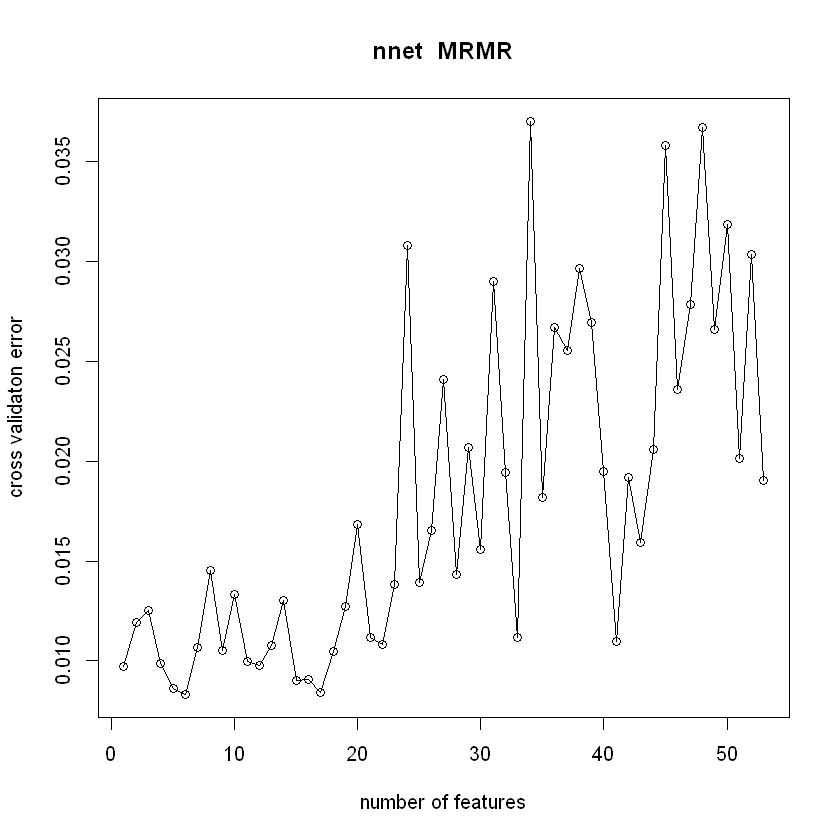

In [46]:
#mrmr('nnet', X, Y)#6  ; CV error= 0.0106  ; std dev= 0.0052

In [ ]:
#pca('nnet', X, Y)# Features:  2  ; CV error= 0.0155  ; std dev= 0.0118

In [109]:
#forwardSelection('nnet', X, Y) #

In [43]:
runEnsemble('nnet', X, Y) #0.0232  

[1] "Ensemble  nnet   CV error= 0.0255  ; std dev= 0.0129"


nnet  filter features:  1  ; CV error= 0.0094  ; std dev= 0.0078
nnet  filter features:  2  ; CV error= 0.0084  ; std dev= 0.0051
nnet  filter features:  3  ; CV error= 0.0088  ; std dev= 0.0052
nnet  filter features:  4  ; CV error= 0.0085  ; std dev= 0.0055
nnet  filter features:  5  ; CV error= 0.0099  ; std dev= 0.0084
nnet  filter features:  6  ; CV error= 0.0099  ; std dev= 0.007
nnet  filter features:  7  ; CV error= 0.0126  ; std dev= 0.0082
nnet  filter features:  8  ; CV error= 0.0125  ; std dev= 0.0105
nnet  filter features:  9  ; CV error= 0.0128  ; std dev= 0.0093
nnet  filter features:  10  ; CV error= 0.0136  ; std dev= 0.0121
nnet  filter features:  11  ; CV error= 0.0096  ; std dev= 0.0059
nnet  filter features:  12  ; CV error= 0.01  ; std dev= 0.007
nnet  filter features:  13  ; CV error= 0.0121  ; std dev= 0.0112
nnet  filter features:  14  ; CV error= 0.0139  ; std dev= 0.016
nnet  filter features:  15  ; CV error= 0.0128  ; std dev= 0.0115
nnet  filter features:  

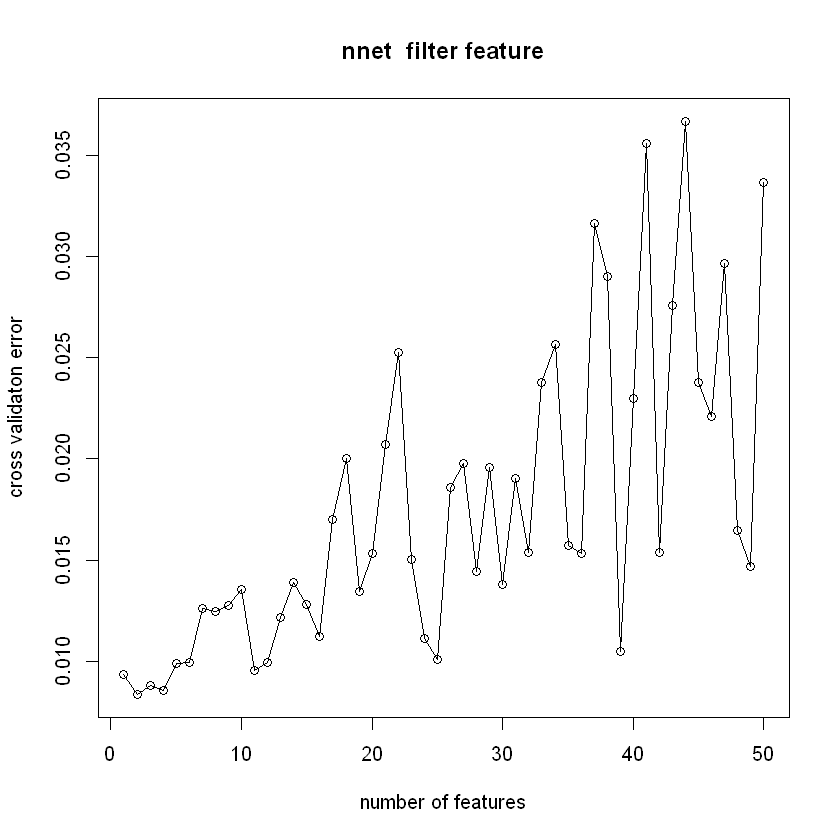

In [49]:
X<- data[1:nrow(input),]
#the winner is
nnetIndexes <- outputCorrelation('nnet', X, Y)


In [50]:
nnetIndexes <- nnetIndexes[1: 12]

## RIDGE

In [57]:
X<- data[1:nrow(input),]
runModel('ridge', X, Y, 4) # 0.0066

[1] "ridge   CV error= 0.0066  ; std dev= 0.0066"


ridge  filter features:  1  ; CV error= 0.035  ; std dev= 0.0336
ridge  filter features:  2  ; CV error= 0.0085  ; std dev= 0.0071
ridge  filter features:  3  ; CV error= 0.0093  ; std dev= 0.0065
ridge  filter features:  4  ; CV error= 0.0089  ; std dev= 0.0059
ridge  filter features:  5  ; CV error= 0.0092  ; std dev= 0.0076
ridge  filter features:  6  ; CV error= 0.0087  ; std dev= 0.0082
ridge  filter features:  7  ; CV error= 0.0083  ; std dev= 0.0073
ridge  filter features:  8  ; CV error= 0.0083  ; std dev= 0.0078
ridge  filter features:  9  ; CV error= 0.0085  ; std dev= 0.008
ridge  filter features:  10  ; CV error= 0.0106  ; std dev= 0.0075
ridge  filter features:  11  ; CV error= 0.0106  ; std dev= 0.0075
ridge  filter features:  12  ; CV error= 0.0102  ; std dev= 0.0067
ridge  filter features:  13  ; CV error= 0.01  ; std dev= 0.0067
ridge  filter features:  14  ; CV error= 0.01  ; std dev= 0.0066
ridge  filter features:  15  ; CV error= 0.0101  ; std dev= 0.0061
ridge  fil

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21 32  2 33 49 10 47 14 29 43 50 15
[26] 22 37 42 24 34 30 45 46 44 48  1 31 25 27 28  4 40 23 35 26 41 36 11 39 38

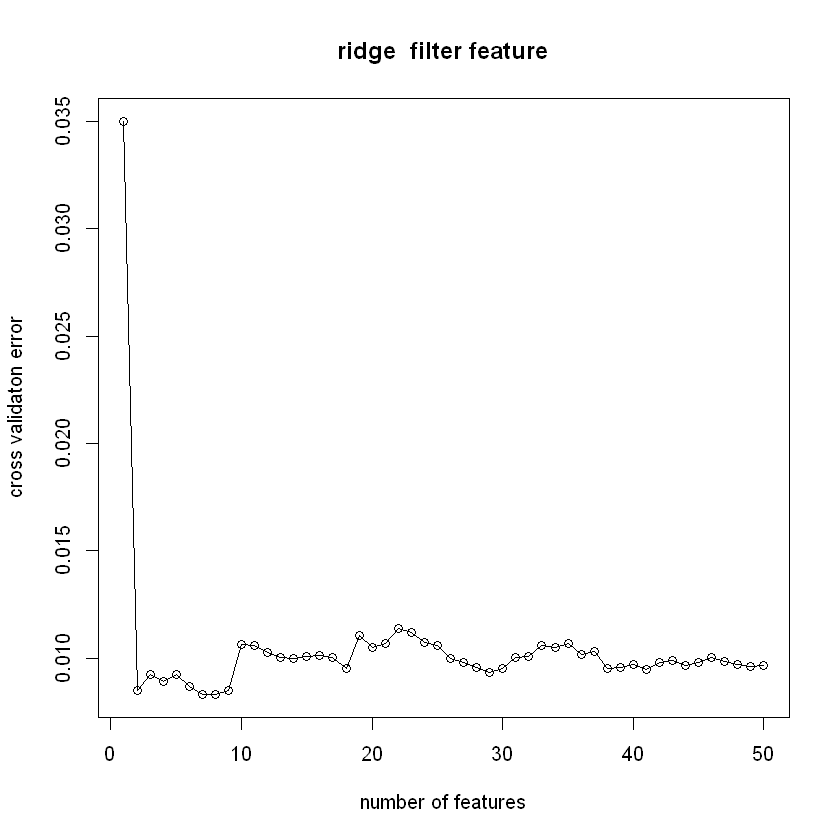

In [219]:
outputCorrelation('ridge', X, Y)

ridge Features:  1  ; CV error= 0.035  ; std dev= 0.0336
ridge Features:  2  ; CV error= 0.0092  ; std dev= 0.0083
ridge Features:  3  ; CV error= 0.011  ; std dev= 0.009
ridge Features:  4  ; CV error= 0.0085  ; std dev= 0.0066
ridge Features:  5  ; CV error= 0.0088  ; std dev= 0.0058
ridge Features:  6  ; CV error= 0.0073  ; std dev= 0.006
ridge Features:  7  ; CV error= 0.0077  ; std dev= 0.0065
ridge Features:  8  ; CV error= 0.0079  ; std dev= 0.0072
ridge Features:  9  ; CV error= 0.0084  ; std dev= 0.0065
ridge Features:  10  ; CV error= 0.008  ; std dev= 0.0066
ridge Features:  11  ; CV error= 0.0091  ; std dev= 0.0067
ridge Features:  12  ; CV error= 0.0093  ; std dev= 0.0069
ridge Features:  13  ; CV error= 0.0098  ; std dev= 0.0068
ridge Features:  14  ; CV error= 0.0099  ; std dev= 0.0073
ridge Features:  15  ; CV error= 0.0088  ; std dev= 0.0064
ridge Features:  16  ; CV error= 0.0094  ; std dev= 0.0066
ridge Features:  17  ; CV error= 0.0102  ; std dev= 0.0065
ridge Featu

[1]  3 47 18  9 49  5  8  6 43 19 17 12 16 29 32  7 50 22 20 13 21 15 10  2 33
[26] 42 14 30 24 45  4 37 31 34 46  1 48 44 28 27 40 25 26 23 41 35 11 36 38 39

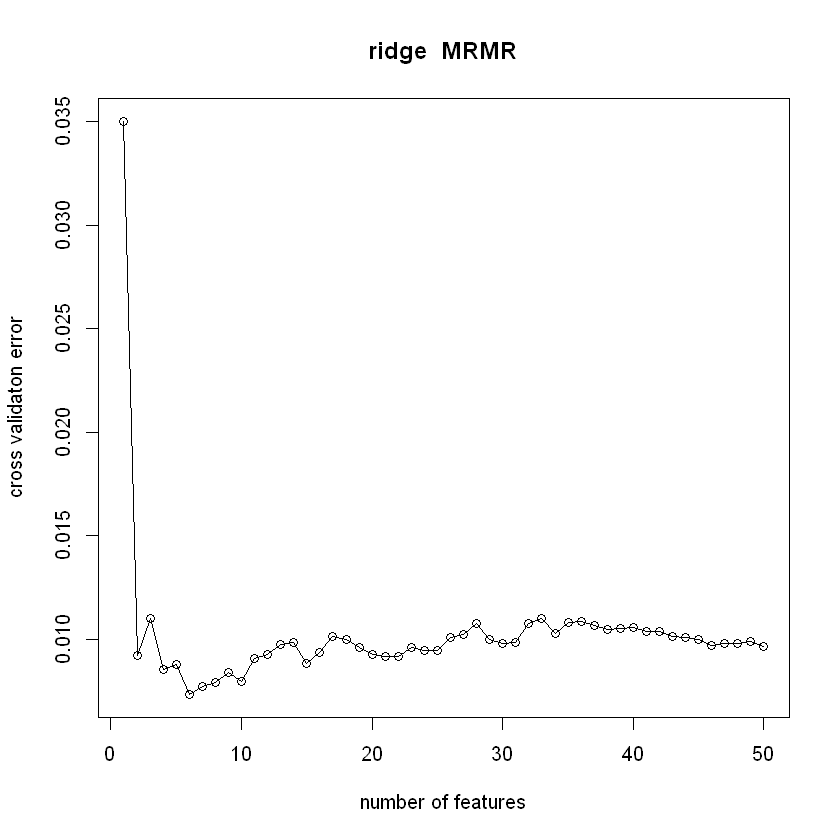

In [220]:
mrmr('ridge', X, Y)

ridge  filter features:  1  ; CV error= 0.035  ; std dev= 0.0336
ridge  filter features:  2  ; CV error= 0.0085  ; std dev= 0.0071
ridge  filter features:  3  ; CV error= 0.0093  ; std dev= 0.0065
ridge  filter features:  4  ; CV error= 0.0089  ; std dev= 0.0059
ridge  filter features:  5  ; CV error= 0.0092  ; std dev= 0.0076
ridge  filter features:  6  ; CV error= 0.0087  ; std dev= 0.0082
ridge  filter features:  7  ; CV error= 0.0083  ; std dev= 0.0073
ridge  filter features:  8  ; CV error= 0.0083  ; std dev= 0.0078
ridge  filter features:  9  ; CV error= 0.0085  ; std dev= 0.008
ridge  filter features:  10  ; CV error= 0.0106  ; std dev= 0.0075
ridge  filter features:  11  ; CV error= 0.0106  ; std dev= 0.0075
ridge  filter features:  12  ; CV error= 0.0102  ; std dev= 0.0067
ridge  filter features:  13  ; CV error= 0.01  ; std dev= 0.0067
ridge  filter features:  14  ; CV error= 0.01  ; std dev= 0.0066
ridge  filter features:  15  ; CV error= 0.0101  ; std dev= 0.0061
ridge  fil

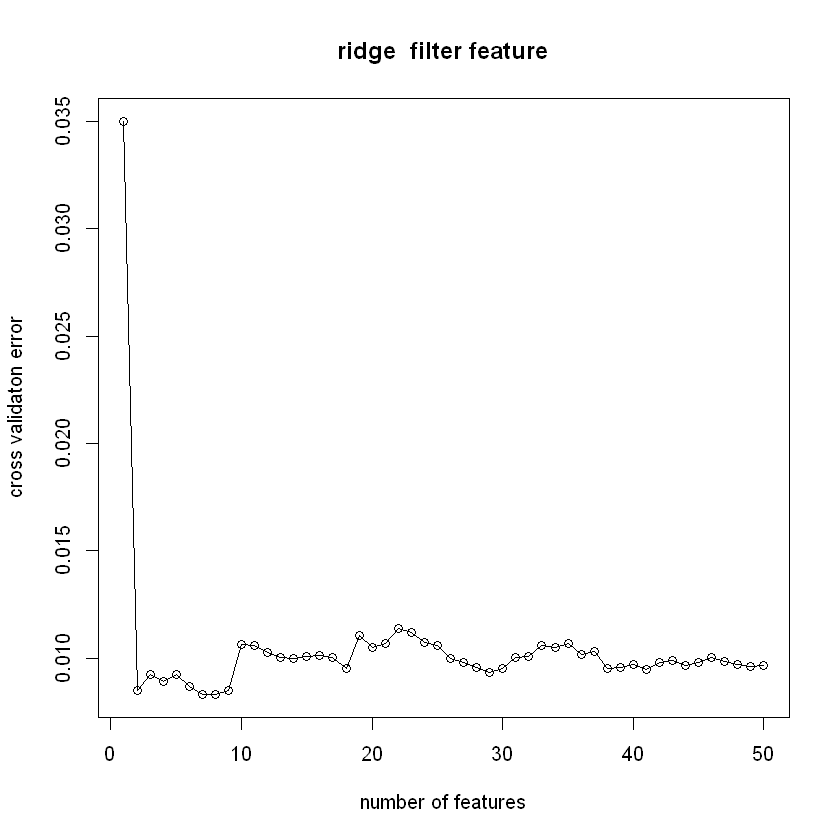

In [222]:
X<- data[1:nrow(input),]
#the winner is
ridgeIndexes <- outputCorrelation('ridge', X, Y)

In [223]:
ridgeIndexes <- ridgeIndexes[1: 29]

## Compare models 

The table below summaries the results of running each individual algorithm as ensemble.

Based on these results we can decide how we can mix and match these algorithms, searching for the best performance.


The code below saves on the disk the optimised features for each algorithm :

In [224]:
rpartIndexes
write(rpartIndexes, 'rpartIndexes.txt', sep =',')
svmIndexes
write(svmIndexes, 'svmIndexes.txt', sep =',')
lazyIndexes
write(lazyIndexes, 'lazyIndexes.txt', sep =',')
treeIndexes
write(treeIndexes, 'treeIndexes.txt', sep =',')
lmIndexes
write(lmIndexes, 'lmIndexes.txt', sep =',')
nnetIndexes
write(nnetIndexes, 'nnetIndexes.txt', sep =',')
ridgeIndexes
write(ridgeIndexes, 'ridgeIndexes.txt', sep =',')

[1]  3 47 18  9 49  5  8  6 43 19 17 12 16 29 32  7 50 22 20 13 21 15 10  2 33
[26] 42 14 30 24 45  4 37 31 34

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21 32

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21  2 10 14 15

[1]  3 14  1  4  7 10 11 13 15 20 21 22 23 24 25 26 27 28  6 18  8 17

[1]  3  9  5 44 20 19 23  1 35 36 50 34 45 11 38 26 30  7 43 22 39 13 40 27 21

[1]  3  9 18 19  8 12  5  6 16 17  7 20

[1]  3  9 18 19  8 12  5  6 16 17  7 20 13 21 32  2 33 49 10 47 14 29 43 50 15
[26] 22 37 42 24

In [61]:
X<- data[1:nrow(input),]
 

In [301]:
magicEnsemble(c('rpart'), list(rpartIndexes), data[1:nrow(input),], Y, 5, 10)

[1] "Magic Ensemble for rpart   CV error= 0.0189  ; std dev= 0.0099"


[1] 0.0189

In [273]:
magicEnsemble(c('svm'), list(svmIndexes), data[1:nrow(input),], Y, 2, 10)

[1] "Magic Ensemble for svm   CV error= 0.01  ; std dev= 0.0082"


[1] 0.01

In [64]:
magicEnsemble(c('lm'), list(lmIndexes), data[1:nrow(input),], Y, 5, 10)

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Magic Ensemble  lm   CV error= 0.0044  ; std dev= 0.004"


In [299]:
magicEnsemble(c('nnet'), list(nnetIndexes), data[1:nrow(input),], Y, 10, 10) #0.0088


[1] "Magic Ensemble for nnet   CV error= 0.0112  ; std dev= 0.0082"


[1] 0.0112

In [66]:
magicEnsemble(c('lazy'), list(lazyIndexes), data[1:nrow(input),], Y, 5, 10)

[1] "Magic Ensemble  lazy   CV error= 0.0444  ; std dev= 0.0519"


In [80]:
magicEnsemble(c('tree'), list(treeIndexes), data[1:nrow(input),], Y, 10, 10)

[1] "Magic Ensemble  tree   CV error= 0.0178  ; std dev= 0.0099"


In [230]:
magicEnsemble(c('ridge'), list(ridgeIndexes), data[1:nrow(input),], Y, 5, 10) #0.0097

[1] "Magic Ensemble for ridge   CV error= 0.0092  ; std dev= 0.0062"


[1] 0.0092

In [605]:
stackedEnsemble(c('ridge', 'tree', 'lazy'), list(ridgeIndexes, treeIndexes, lazyIndexes), data[1:nrow(input),], Y, 5, 10)

[1] "Magic Ensemble for ridge,tree,lazy   CV error= 0.0275  ; std dev= 0.0295"


[1] 0.0275

In [ ]:
stackedEnsemble(c('ridge', 'lm'), list(ridgeIndexes, lmIndexes), data[1:nrow(input),], Y, 5, 10)

In [ ]:
stackedEnsemble(c('svm'), list(svmIndexes), data[1:nrow(input),], Y, 5, 10)

With magicEnsemble we can easily plot the dependency between the number of folds/ samplings and the CV:

[1] "Magic Ensemble  ridge   CV error= 0.0014  ; std dev= 1e-04"
[1] "Magic Ensemble  ridge   CV error= 0.0066  ; std dev= 0.0066"
[1] "Magic Ensemble  ridge   CV error= 0.0108  ; std dev= 0.0078"
[1] "Magic Ensemble  ridge   CV error= 0.0146  ; std dev= 0.0092"
[1] "Magic Ensemble  ridge   CV error= 0.0097  ; std dev= 0.0049"
[1] "Magic Ensemble  ridge   CV error= 0.0114  ; std dev= 0.0081"
[1] "Magic Ensemble  ridge   CV error= 0.0106  ; std dev= 0.0089"
[1] "Magic Ensemble  ridge   CV error= 0.0135  ; std dev= 0.0137"
[1] "Magic Ensemble  ridge   CV error= 0.0142  ; std dev= 0.0133"
[1] "Magic Ensemble  ridge   CV error= 0.0153  ; std dev= 0.0098"


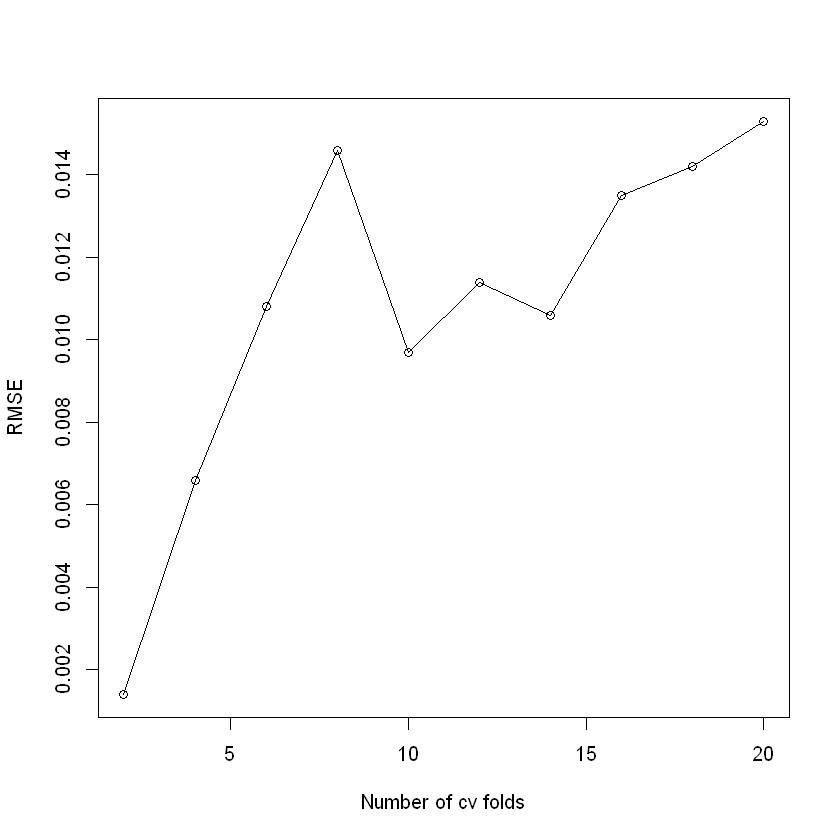

In [132]:
xVal <-1:10
yVal <- numeric(10)

for( i in 1:10) {
    
    yVal[i] <- as.numeric(magicEnsemble(c('ridge'), list(NULL), data[1:nrow(input),], Y, 1, i *2))

}

plot(2*xVal, yVal, type="o", xlab = 'Number of cv folds', ylab = 'RMSE')

We obtain the following summary of results:

| Algorithm | RMSE | Features      
| :- |:-|:-
| lm | 0.0044  |lmIndexes
| nnet |0.0088   |nnetIndexes
| ridge | 0.0098 | ridgeIndexes
| svm |0.0156   |svmIndexes
| rpart | 0.0172 |rpartIndexes
| tree |0.0178 | treeIndexes
| lazy |0.0508   |lazyIndexes

Now let's combine predictors and see how this influences cv:

In [182]:

magicEnsemble(c('nnet' , 'ridge'), list(nnetIndexes, NULL), data[1:nrow(input),], Y, 10, 10)#0.0085

[1] "Magic Ensemble  ridge   CV error= 0.0085  ; std dev= 0.0056"


[1] 0.0085

In [186]:

magicEnsemble(c('nnet' , 'ridge', 'lm'), list(nnetIndexes, NULL, lmIndexes), data[1:nrow(input),], Y, 10, 10)#0.0067

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Magic Ensemble  lm   CV error= 0.0067  ; std dev= 0.0052"


[1] 0.0067

In [187]:
magicEnsemble(c('nnet' , 'ridge', 'svm'), list(nnetIndexes, NULL, svmIndexes), data[1:nrow(input),], Y, 10, 10)#0.0095

[1] "Magic Ensemble  svm   CV error= 0.0095  ; std dev= 0.0066"


[1] 0.0095

In [189]:
magicEnsemble(c('tree' , 'ridge', 'lazy'), list(treeIndexes, NULL, lazyIndexes), data[1:nrow(input),], Y, 10, 10) #0.0129

[1] "Magic Ensemble  lazy   CV error= 0.0129  ; std dev= 0.01"


[1] 0.0129

In [192]:
magicEnsemble(c('nnet' , 'rpart'), list(nnetIndexes, rpartIndexes), data[1:nrow(input),], Y, 10, 10) #0.0127

[1] "Magic Ensemble  rpart   CV error= 0.0127  ; std dev= 0.0093"


[1] 0.0127

In [193]:
magicEnsemble(c('nnet' , 'tree'), list(nnetIndexes, treeIndexes), data[1:nrow(input),], Y, 10, 10) #0.0105

[1] "Magic Ensemble  tree   CV error= 0.0105  ; std dev= 0.0073"


[1] 0.0105

In [195]:
magicEnsemble(c('ridge' , 'tree'), list(NULL, treeIndexes), data[1:nrow(input),], Y, 10, 10) 
#0.0104 ridge and tree is better than tree and nnet

[1] "Magic Ensemble for ridge,tree   CV error= 0.0104  ; std dev= 0.0064"


[1] 0.0104

In [196]:
magicEnsemble(c('ridge' , 'rpart'), list(NULL, rpartIndexes), data[1:nrow(input),], Y, 10, 10) 

[1] "Magic Ensemble for ridge,rpart   CV error= 0.0115  ; std dev= 0.0074"


[1] 0.0115

In [198]:
magicEnsemble(c('lm' , 'tree'), list(lmIndexes, treeIndexes), data[1:nrow(input),], Y, 10, 10) #0.0093

Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, X.ts):
"prediction from a rank-deficient fit may be misleading"

[1] "Magic Ensemble for lm,tree   CV error= 0.0093  ; std dev= 0.004"


[1] 0.0093

### Prediction

The method below performs an ensemble average predition of given models ( with given modelFeatures).
TrainX and trainY represent the train dataset and test the data on which we want to perform the prediction.

The method below combines the given models, performs CV and resampling and at the end returns the averaged prediction.

In [614]:
meanPredict <- function(models, modelFeatures, X, Y, test, R, CV){

  size.CV<-floor(N/CV)
  
  CV.err<-numeric(CV)
  
  for (i in 1:CV) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV)) 
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)        
    Y.hat.ts.R<-matrix(0,nrow=nrow(test),ncol= R * length(models))
    
    for( mi in 1: length(models)){
      modelName = models[mi]
      for (r in 1:R) {
        index <- (mi -1 ) * R + r
        
        i.tr.resample<-sample(i.tr,rep=T)
        if(R == 1) { #prevent resampling for R = 1
            i.tr.resample <- i.tr
        }
        
        X.tr<-X[i.tr.resample,]
        Y.tr<-Y[i.tr.resample]       
        
        #for each model feature, use its optimised features
        if(!is.null(modelFeatures) && !is.null(modelFeatures[[mi]])) {
          X.tr <- X.tr[, modelFeatures[[mi]]]
        }
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts.R[, index] <- predict(model,test)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,test)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,test)
        }
        if(modelName == 'svm'){
            model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
                     shrinking = T, cross = 5, cost = 4, epislon = 0.2)
          #model<- svm(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,test)
        }
        if(modelName == 'nnet'){
          DS <- scale_df(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
          Y.hat.ts.R[,index] <- predict(model,scale_df(test))
          Y.hat.ts.R[,index] <- unscale(Y.hat.ts.R[,index], sd(Y), mean(Y))
          #Y.hat.ts.R[,index] <- predict(model,test)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts.R[,index]<- predict(model,test)$h
        }
        
        if(modelName == 'ridge'){
           #DS is performing a sdv which fails for columns with 0 after scaling
           #let's remove these columns
          DS <- DS[,which(colSums(DS)!=0)]
          model<- linearRidge(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,test)
        }
      }
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    
  }
  
  
  print('done')
  Y.hat.ts
}


The method below performs CV and R resamples on given models and then stacks the results. It applies linear ridge (the algorithm which worked best so far) on the stacked dataset.

All this is performed in a cross validated way so we also average the stacked results for the CV validation folds.

See the pseudocode for this approach above (stackedEnsemble).

In [627]:
stackedPredict <- function(models, modelFeatures, X, Y, test, R, CV){

  size.CV<-floor(N/CV)
  
  CV.err<-numeric(CV)
  result<-matrix(0,nrow=nrow(test),ncol= CV)
  
  for (i in 1:CV) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV)) 
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)        
    Y.hat.ts.R<-matrix(0,nrow=nrow(test),ncol= R * length(models))
      

    stacking_train_dataset<-matrix(0,nrow=length(i.tr),ncol= R * length(models))
    stacking_test_dataset<-matrix(0,nrow=nrow(test),ncol= R * length(models))
    
    for( mi in 1: length(models)){
      modelName = models[mi]
      for (r in 1:R) {
        index <- (mi -1 ) * R + r
        
        i.tr.resample<-sample(i.tr,rep=T)
        if(R == 1) { #prevent resampling for R = 1
            i.tr.resample <- i.tr
        }
        
        X.tr<-X[i.tr.resample,]
        Y.tr<-Y[i.tr.resample]       
        
        #for each model feature, use its optimised features
        if(!is.null(modelFeatures) && !is.null(modelFeatures[[mi]])) {
          X.tr <- X.tr[, modelFeatures[[mi]]]
        }
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,test)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,test)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,test)
        }
        if(modelName == 'svm'){
            model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
                     shrinking = T, cross = 5, cost = 4, epislon = 0.2)
            stacking_train_dataset[,index] <- predict(model,X.tr)
            stacking_test_dataset[,index] <- predict(model,test)
        }
        if(modelName == 'nnet'){
          #DS <- scale_df(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3, trace=FALSE)
          #Y.hat.ts.R[,index] <- predict(model,scale_df(test))
          #Y.hat.ts.R[,index] <- unscale(Y.hat.ts.R[,index], sd(Y), mean(Y))
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,test)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          stacking_train_dataset[,index] <- predict(model,X.tr)$h
          stacking_test_dataset[,index] <- predict(model,test)$h
        }
        
        if(modelName == 'ridge'){
           #DS is performing a sdv which fails for columns with 0 after scaling
           #let's remove these columns
          DS <- DS[,which(colSums(DS)!=0)]
          model<- linearRidge(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,test)
          stacking_train_dataset[,index] <- predict(model,X.tr)
          stacking_test_dataset[,index] <- predict(model,test)
        }
      }
    }
    
    stacked <- as.data.frame(stacking_train_dataset)

    stacked$SalePrice <- Y.tr  
    model<- lm(SalePrice~.,stacked)
    result[,i] <- predict(model,as.data.frame(stacking_test_dataset))
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    
  }
  
  
  print('stacked done')
  apply(result,1,mean)
}


The following method writes to submission.csv the result outputed by given selection.

It recalculates original price as we transformed y = log(y_i + 1)

In [142]:
writePredictionToFile <- function (prediction) {
  predictedSalePrice <- exp(prediction) -1
  result <- cbind(Id = output$Id, SalePrice = predictedSalePrice )
  colnames(result) <- c("Id","SalePrice")
  write.csv(result, "submission.csv",row.names=FALSE)
}


In [158]:
test <- data[(nrow(input) + 1):nrow(numeric.df),]

In [184]:
prediction <- meanPredict(c('nnet' , 'ridge'), list(nnetIndexes, NULL), data[1:nrow(input),], Y, test, 10, 10)

[1] "done"


In [456]:
prediction <- meanPredict(c('nnet' ), list(nnetIndexes), data[1:nrow(input),], Y, test, 2, 2) #0.17208

[1] "done"


In [271]:
prediction <- meanPredict(c('lm' , 'ridge'), list(lmIndexes, ridgeIndexes), data[1:nrow(input),], Y, test, 10, 10) #0.15415

Warning message in predict.lm(model, test):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, test):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, test):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, test):
"prediction from a rank-deficient fit may be misleading"

[1] "done"


In [66]:
prediction <- meanPredict(c('nnet' , 'ridge'), list(nnetIndexes, NULL), data[1:nrow(input),], Y, test, 10, 10)

[1] "done"


In [295]:
prediction <- meanPredict(c('svm'), list(svmIndexes), data[1:nrow(input),], Y, test, 2, 2)

[1] "done"


In [207]:
prediction <- meanPredict(c('nnet' , 'ridge'), list(nnetIndexes, NULL), data[1:nrow(input),], Y, test, 10, 10)

[1] "done"


In [209]:
prediction <- meanPredict(c('nnet' , 'ridge'), list(nnetIndexes, NULL), data[1:nrow(input),], Y, test, 10, 10)

[1] "done"


In [317]:
prediction <- meanPredict(c('nnet' , 'ridge'), list(nnetIndexes, NULL), data[1:nrow(input),], Y, test, 10, 10)

[1] "done"


In [634]:
prediction <- stackedPredict(c( 'ridge'), list( NULL), data[1:nrow(input),], Y, test, 10, 10)#0.13921

[1] "stacked done"


In [632]:
prediction <- stackedPredict(c( 'ridge', 'svm'), list( ridgeIndexes, svmIndexes), data[1:nrow(input),], Y, test, 10, 10)

[1] "stacked done"


In [637]:
writePredictionToFile(prediction)

## Discussion and conclusions

The biggest challanges encountered while solving this machine learning problem were:

- understanding the model and the relationships between features. It is a typical scenario illustrating "the curse of dimensionality", as the input has 80 explanatory variables, half of which are categorical and afther the one hot encoding the number of features increases even more. In a first phase I used data visualisation techniques to identify the features in which we have only one dominant value (the other values being under-represented) and remove them as they wouldn't be able to provide relevant data for predictions


- in order to facilitate the selection of models/ features after a potentially long trial and error process configurable building blocks (functions) were the best approach


- find in the summary table above a comparison between the performances of individual algorithms run as ensemble


- in order to accomodate the particularities of each method, custom code was developed. For instance, for ridge regression before training the model we have to remove all columns with 0 (otherwise after scaling sdv throws exception) and make sure that the trainig set had at least 2 features


- for all algorithmns I used both scaled and unscaled data (see df_scale and unscale methods), it turns out that scaling doesn't improve significantly the accuracy


- from all algorithms the best score was obtained with ridge linear regression followed by lm and neural network


- the stacked ensemble performs better than the average ensemble, the best score was obtained with stacked ensemble and passing along a ridge model


- The calls to some of the functions based on which the features were selected have been commented out because their execution takes too long and once the selection has been done I wanted to avoid accidentaly running them 


- Linear ridge provided the best results. It performs an auto scaling which fails if there are columns with sd 0, so as explained in the comments these columns have been taken out



My Kaggle account is INFOF422Ciortan